# Brain Tumor Detection

In [ ]:
!pip install -U git+https://github.com/amitness/colab-connect.git
from colabconnect import colabconnect
colabconnect()


  Cloning https://github.com/amitness/colab-connect.git to /tmp/pip-req-build-npqibh47
  Running command git clone --filter=blob:none --quiet https://github.com/amitness/colab-connect.git /tmp/pip-req-build-npqibh47
  Resolved https://github.com/amitness/colab-connect.git to commit a2e2c7901fc57e4d833645925243582081ee00e8
  Preparing metadata (setup.py) ... done
Mounting Google Drive...
Mounted at /content/drive
Ran: ln -s /content/drive/MyDrive/colab/ /
Installing python libraries...
Ran: pip3 install --user flake8 black ipywidgets twine
Ran: pip3 install -U ipykernel
Ran: apt install htop -y
Installing vscode-cli...
Ran: curl -Lk https://code.visualstudio.com/sha/download?build=stable&os=cli-alpine-x64 --output vscode_cli.tar.gz
Ran: tar -xf vscode_cli.tar.gz
Starting the tunnel
To grant access to the server, please log into https://github.com/login/device and use code 5FAD-FF9C
Starting the tunnel
- Ready!
- Open VSCode on your laptop and open the command prompt
- Select: 'Remote-Tu

## 1. Dataset Selection

For this project, I chose the **Brain Tumor Classification Dataset**, which is publicly available on [Kaggle](https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c). This dataset contains **MRI scan images** categorized into **multiple tumor types**, including:

- Astrocytoma  
- Glioblastoma  
- Meningioma  
- Medulloblastoma  
- Normal brain scans (control group)  

This dataset is ideal for **deep learning in medical imaging**, particularly for training **convolutional neural networks (CNNs)** to classify different types of brain tumors from MRI images.


### Importing necessary libraries

In [ ]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import Deep learning Libraries
#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

### Downloading the dataset

In [ ]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/brain-tumor-mri-images-44c")

print("Path to dataset files:", path)

filepaths=[]
labels=[]


folds = os.listdir(path)
for fold in folds:
    foldpath = os.path.join(path, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        # Select just tumor name
        fold = str(fold).replace('C+', '')
        labels.append(fold[:-3])


# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
df

Path to dataset files: /kaggle/input/brain-tumor-mri-images-44c


filepaths     labels
0     /kaggle/input/brain-tumor-mri-images-44c/Papil...   Papiloma
1     /kaggle/input/brain-tumor-mri-images-44c/Papil...   Papiloma
2     /kaggle/input/brain-tumor-mri-images-44c/Papil...   Papiloma
3     /kaggle/input/brain-tumor-mri-images-44c/Papil...   Papiloma
4     /kaggle/input/brain-tumor-mri-images-44c/Papil...   Papiloma
...                                                 ...        ...
4474  /kaggle/input/brain-tumor-mri-images-44c/Germi...  Germinoma
4475  /kaggle/input/brain-tumor-mri-images-44c/Germi...  Germinoma
4476  /kaggle/input/brain-tumor-mri-images-44c/Germi...  Germinoma
4477  /kaggle/input/brain-tumor-mri-images-44c/Germi...  Germinoma
4478  /kaggle/input/brain-tumor-mri-images-44c/Germi...  Germinoma

[4479 rows x 2 columns]



## 2. Dataset Description and Balancing

This dataset supports the task of **multi-class image classification**, where each MRI image is labeled with the specific tumor type it represents. Its applications include:

- Assisting radiologists by providing second opinions  
- Automated pre-screening in clinical settings  
- Education and research in medical imaging AI  

Images are preprocessed to a consistent format (e.g., 224x224 pixels), making them suitable for popular CNN architectures such as VGG, ResNet, and EfficientNet.

### Splitting The Data

In [ ]:

# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

#80% training - 12% valid - 8% testing

In [ ]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                   shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                     shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                     shuffle= False, batch_size= batch_size)

Found 3582 validated image filenames belonging to 15 classes.
Found 537 validated image filenames belonging to 15 classes.
Found 359 validated image filenames belonging to 15 classes.


### Visualising the data

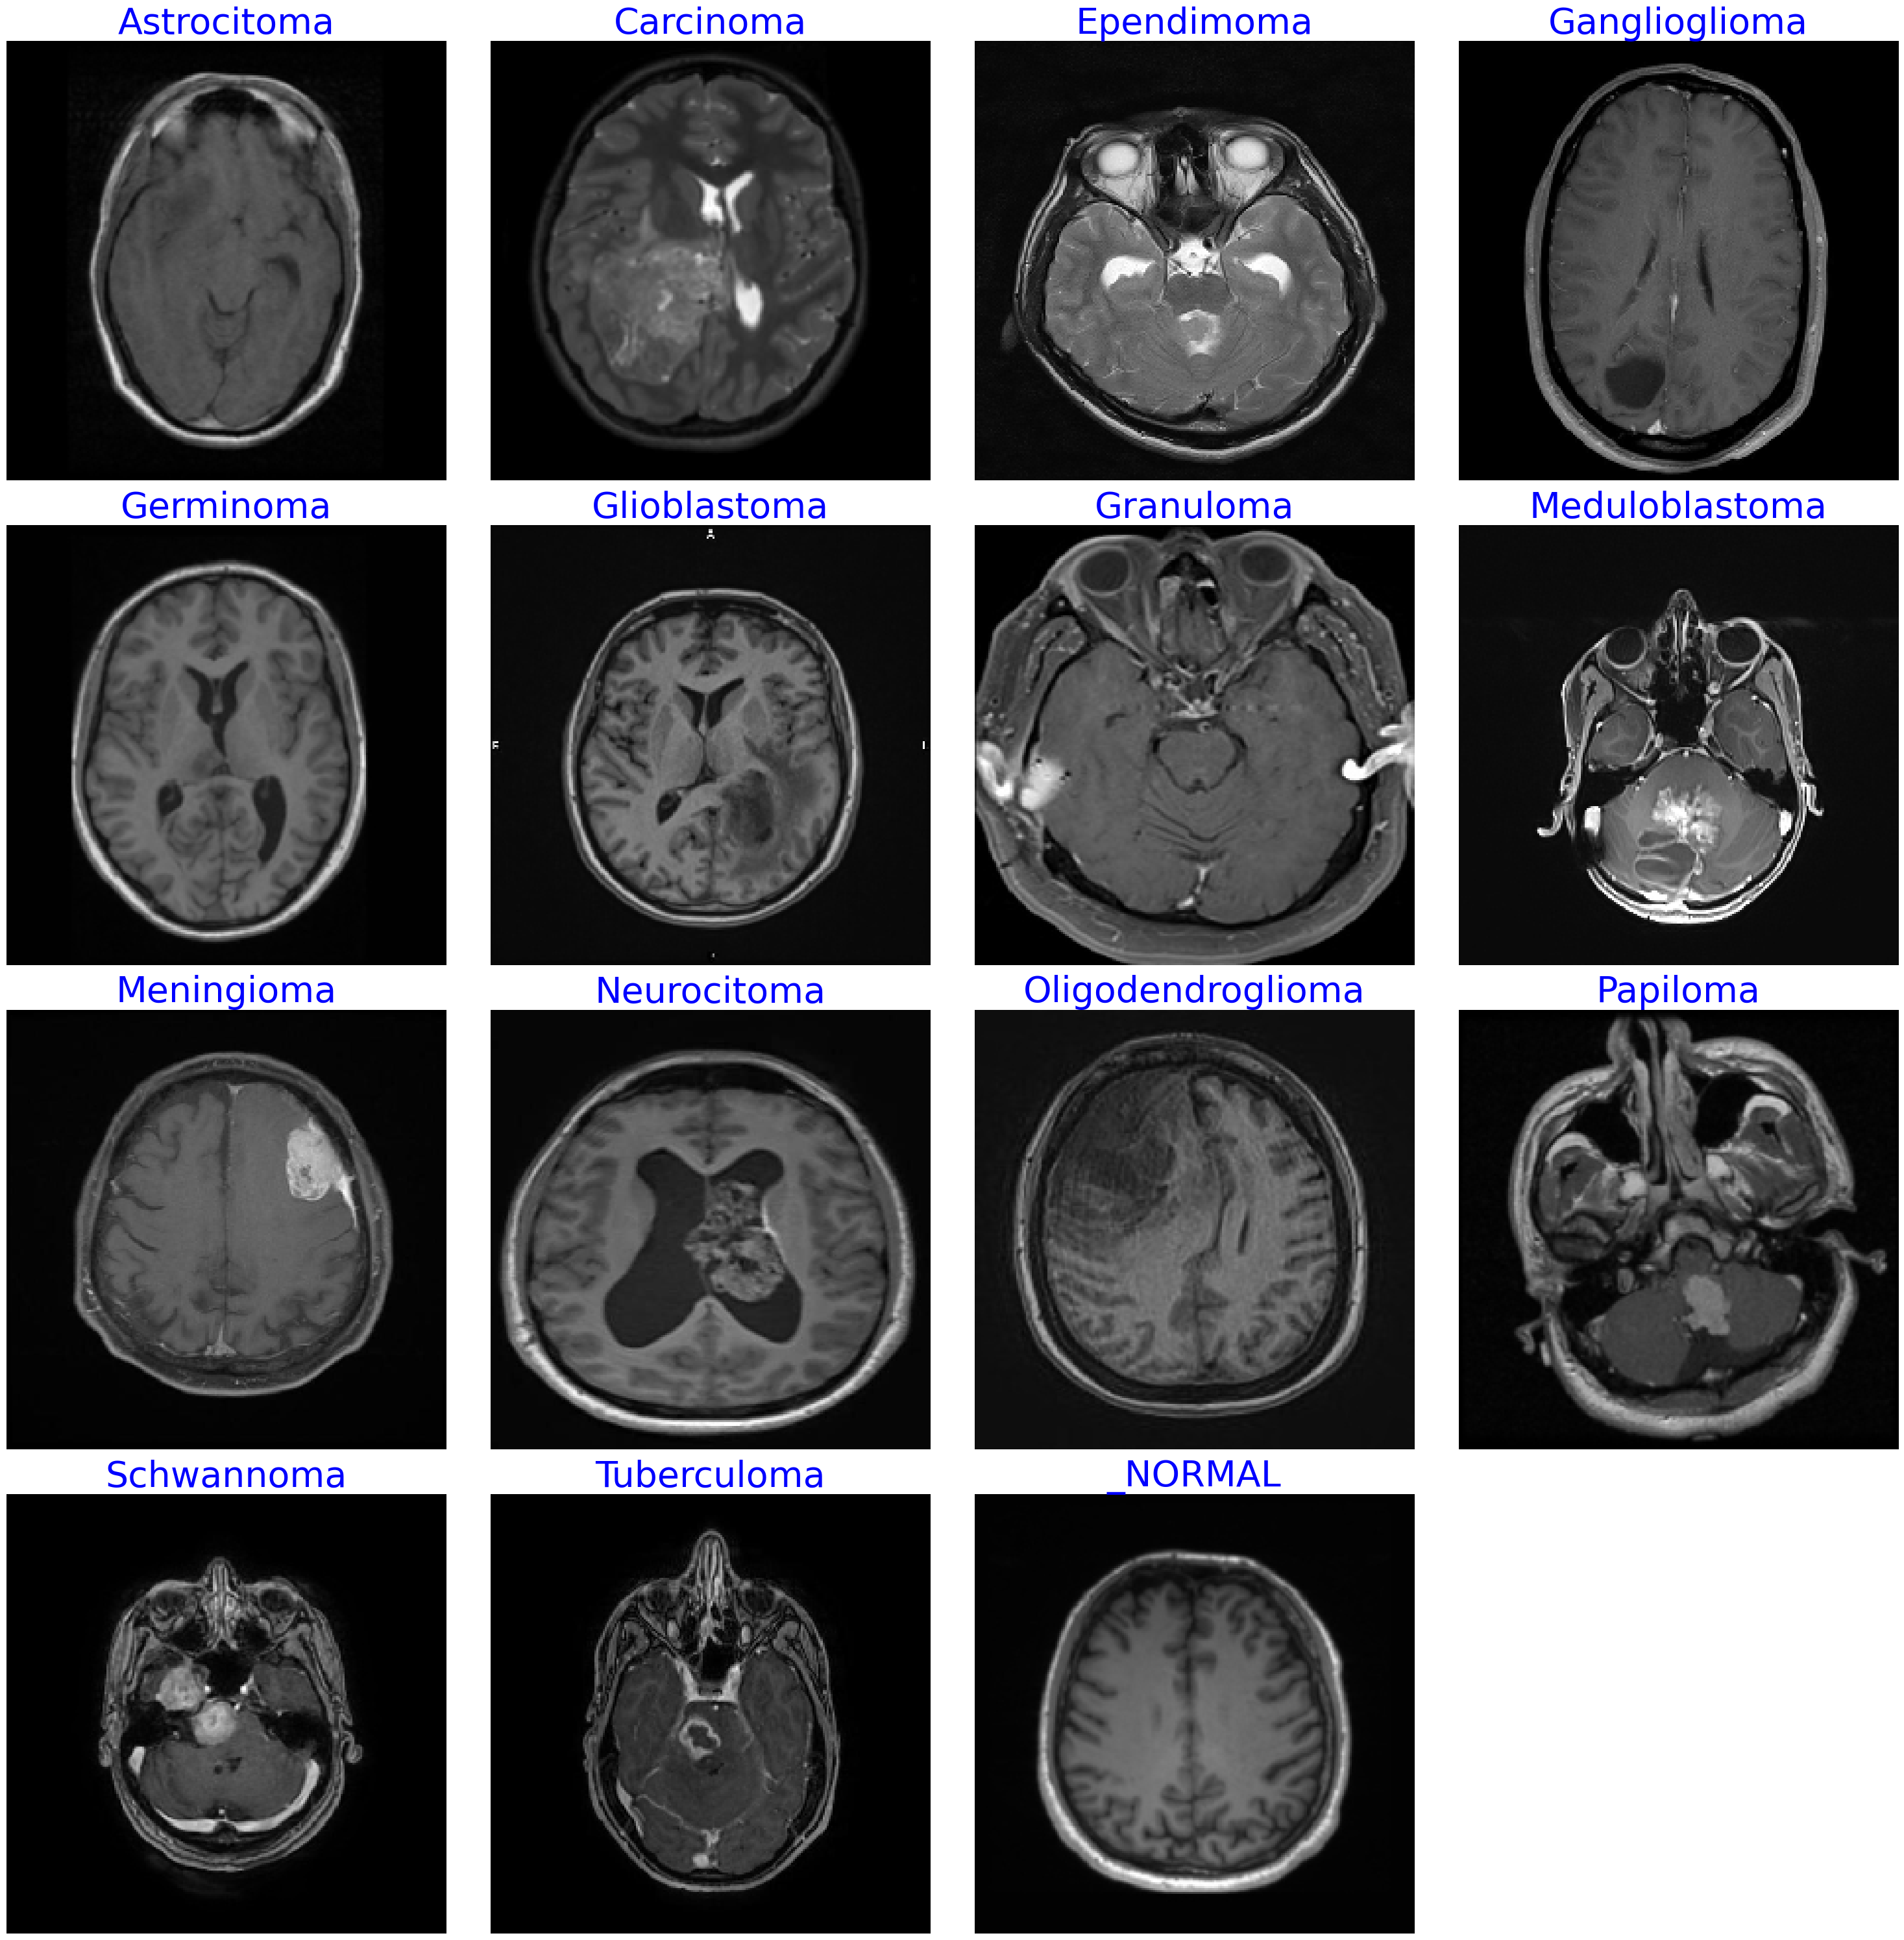

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

g_dict = train_gen.class_indices  # Dictionary mapping class names to indices
classes = list(g_dict.keys())     # List of class names

# Create a dictionary to store one image per class
class_images = {}

# Iterate through the generator until we have one image per class
while len(class_images) < len(classes):
    images, labels = next(train_gen)  # Get a batch of images and labels
    for i in range(images.shape[0]):
        index = np.argmax(labels[i])  # Get the class index
        class_name = classes[index]   # Get the class name
        if class_name not in class_images:
            class_images[class_name] = images[i] / 255  # Store the image

# Plot the images
plt.figure(figsize=(30, 30))
for i, class_name in enumerate(classes):
    plt.subplot(4, 4, i + 1)  # Adjust subplot layout
    plt.imshow(class_images[class_name])
    plt.title(class_name, color='blue', fontsize=40)
    plt.axis('off')
plt.tight_layout()
plt.show()

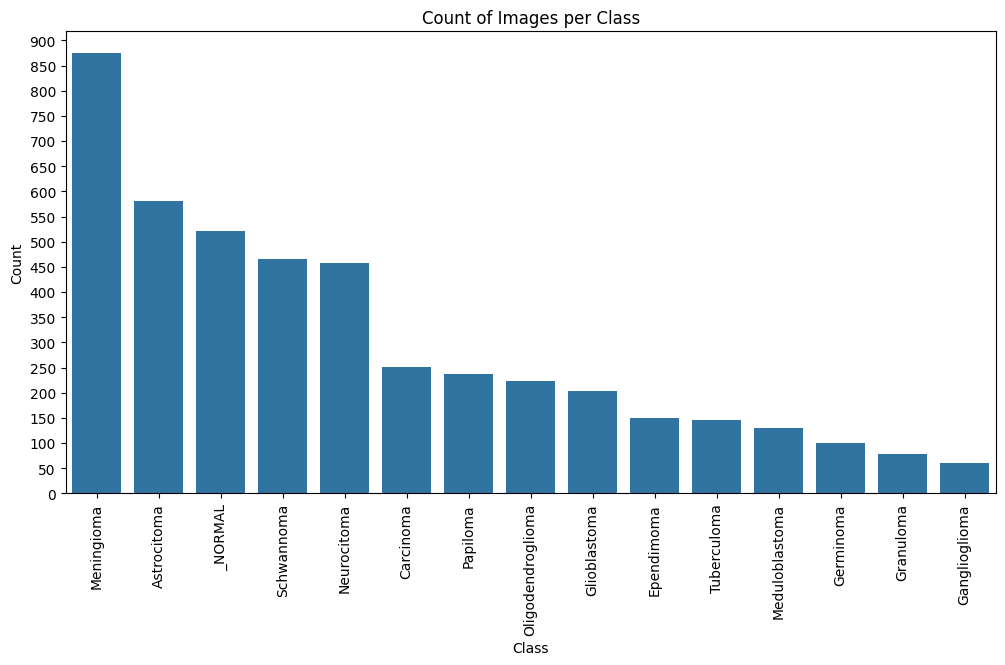

In [ ]:
# Get the counts of each class
class_counts_before = df['labels'].value_counts()

# Create a bar plot using seaborn
plt.figure(figsize=(12, 6))
sns.countplot(x='labels', data=df, order=class_counts_before.index)
plt.title('Count of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.yticks(range(0, int(class_counts_before.max()) + 50, 50))
plt.show()

## 3. Data Preprocessing

In [ ]:
!nvidia-smi


Thu May 22 22:55:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os, shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import tempfile
import pandas as pd

# Setup for augmentation
aug_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

no_aug_gen = ImageDataGenerator()
temp_dir = tempfile.mkdtemp()
augmented_dfs = []

# ✅ Save class counts before augmentation
class_counts_before = df['labels'].value_counts()

# ✅ 1. Check which classes are under 250
classes_to_augment = [cls for cls, count in class_counts_before.items() if count < 250]

# ✅ 2. Generate augmented data for underrepresented classes
for class_name in classes_to_augment:
    current_class_df = df[df['labels'] == class_name]
    num_existing = len(current_class_df)
    num_needed = 250 - num_existing
    saved_files = []

    generator = aug_gen.flow_from_dataframe(
        current_class_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        save_to_dir=temp_dir,
        save_prefix='aug_',
        save_format='jpg'
    )

    while len(saved_files) < num_needed:
        next(generator)
        new_files = [f for f in os.listdir(temp_dir) if f.startswith('aug_')]
        new_paths = [os.path.join(temp_dir, f) for f in new_files]
        for p in new_paths:
            if p not in saved_files:
                saved_files.append(p)
                if len(saved_files) == num_needed:
                    break

    augmented_df = pd.DataFrame({'filepaths': saved_files, 'labels': [class_name] * len(saved_files)})
    augmented_dfs.append(augmented_df)

# ✅ 3. Combine original + augmented into final_df
if augmented_dfs:
    final_df = pd.concat([df] + augmented_dfs, ignore_index=True)
else:
    final_df = df.copy()

# ✅ 4. Get class counts after augmentation
class_counts_after = final_df['labels'].value_counts()

# ✅ 5. Optional: Reduce top-heavy class to match second highest
top_class = class_counts_after.idxmax()
top_count = class_counts_after.max()
second_top_count = class_counts_after.sort_values(ascending=False).iloc[1]

if top_count > second_top_count:
    print(f"Reducing class '{top_class}' from {top_count} to {second_top_count}")
    keep_df = final_df[final_df['labels'] != top_class]
    top_class_df = final_df[final_df['labels'] == top_class].sample(n=second_top_count, random_state=42)
    final_df = pd.concat([keep_df, top_class_df], ignore_index=True)

class_counts_after = final_df['labels'].value_counts()

# ✅ 6. Create final generator from final_df
train_gen = no_aug_gen.flow_from_dataframe(
    final_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)


Found 237 validated image filenames belonging to 1 classes.
Found 224 validated image filenames belonging to 1 classes.
Found 204 validated image filenames belonging to 1 classes.
Found 150 validated image filenames belonging to 1 classes.
Found 145 validated image filenames belonging to 1 classes.
Found 131 validated image filenames belonging to 1 classes.
Found 100 validated image filenames belonging to 1 classes.
Found 78 validated image filenames belonging to 1 classes.
Found 61 validated image filenames belonging to 1 classes.
Reducing class 'Meningioma' from 874 to 580
Found 5104 validated image filenames belonging to 15 classes.


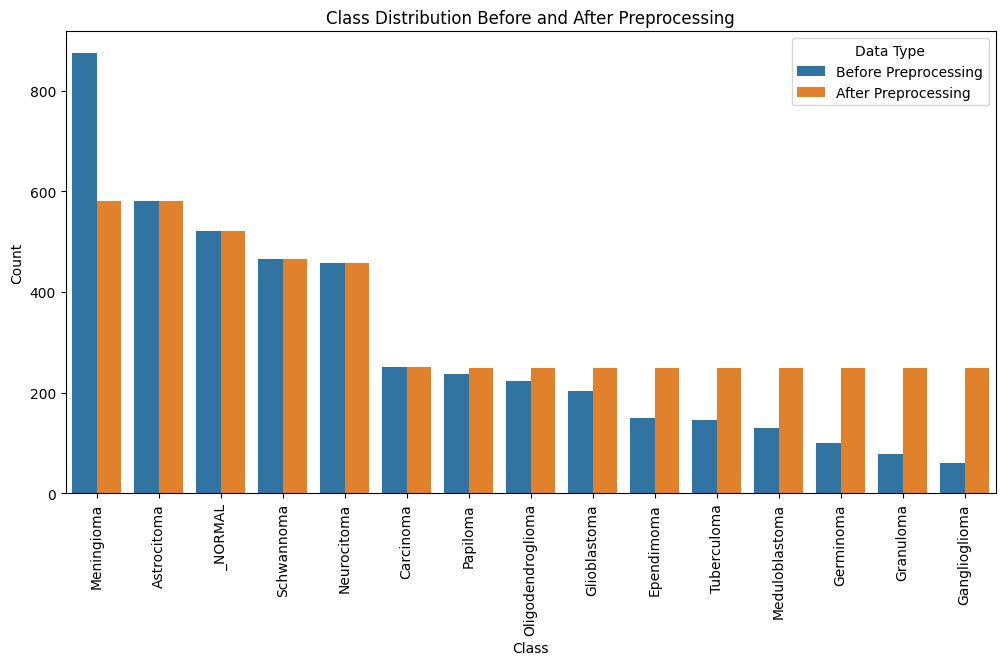

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd



# Create a DataFrame for plotting
before_df = pd.DataFrame({'Class': class_counts_before.index, 'Count': class_counts_before.values, 'Type': 'Before Preprocessing'})
after_df = pd.DataFrame({'Class': class_counts_after.index, 'Count': class_counts_after.values, 'Type': 'After Preprocessing'})
plot_df = pd.concat([before_df, after_df])

# Create the grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', hue='Type', data=plot_df)
plt.title('Class Distribution Before and After Preprocessing')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Data Type')
plt.show()

## 4. Model Building and Evaluation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

def train_model(model, train_gen, valid_gen, epochs=10, verbose=1):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    history = model.fit(
        x=train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        verbose=verbose,
        callbacks=[early_stop, reduce_lr],
        shuffle=True,
    )

    return history


def plot_history(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {index_loss + 1}'
    acc_label = f'best epoch= {index_acc + 1}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, generator, title="Confusion Matrix"):
    """
    Plots a confusion matrix for a given model and data generator.

    Parameters:
    - model: Trained Keras model
    - generator: Keras generator (usually test_gen)
    - title: Title for the plot
    """
    # Get true labels and predicted labels
    y_true = generator.classes
    y_pred_probs = model.predict(generator, steps=np.ceil(generator.samples / generator.batch_size).astype(int))
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_labels = list(generator.class_indices.keys())

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def evaluate_model_performance(model, test_gen):
    # Predict labels
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size + 1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Class labels
    class_labels = list(test_gen.class_indices.keys())


    # Classification Report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Precision, Recall, F1 Score (macro-averaged)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Macro F1 Score: {f1:.4f}")

    # Binarize true labels for multi-class ROC and PR curves
    y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

    # Precision-Recall Curves per class
    precision_dict, recall_dict, pr_auc = {}, {}, {}
    for i in range(len(class_labels)):
        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
        pr_auc[i] = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])

    # Plot Precision-Recall curves
    plt.figure(figsize=(12, 8))
    for i in range(len(class_labels)):
        plt.plot(recall_dict[i], precision_dict[i], label=f'{class_labels[i]} (AP = {pr_auc[i]:.2f})')
    plt.title('Precision-Recall Curve per Class')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()



### Model 1 ( EfficientNetB5 )

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.regularizers import l2

class_count = len(train_gen.class_indices)

# Load the EfficientNetB5 base model
base_model = EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

# Build the full model
efficientNet_model = Sequential([
    base_model,
    Flatten(),
     Dropout(0.5),
    Dense(256, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(class_count, activation='softmax')  # Final layer with softmax for multi-class
])

# Compile the model
efficientNet_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show the model summary
efficientNet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,041,926 (110.79 MB)

 Trainable params: 28,869,183 (110.13 MB)

 Non-trainable params: 172,743 (674.78 KB)

In [ ]:
efficientnet_history = train_model(efficientNet_model, train_gen, valid_gen, epochs=10, verbose=1)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.1301 - loss: 9.2857 - val_accuracy: 0.3464 - val_loss: 6.4202 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.3213 - loss: 6.3429 - val_accuracy: 0.5326 - val_loss: 5.6534 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.4938 - loss: 5.5542 - val_accuracy: 0.6816 - val_loss: 4.9289 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.5887 - loss: 4.9460 - val_accuracy: 0.7561 - val_loss: 4.4115 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.6881 - loss: 4.4138 - val_accuracy: 0.8417 - val_loss: 3.8963 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.7523 - loss: 3.9751 - val_accuracy: 0.9367 - val_loss: 3.3516 - learning_rate: 0.0010
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.7949 - loss: 3.61

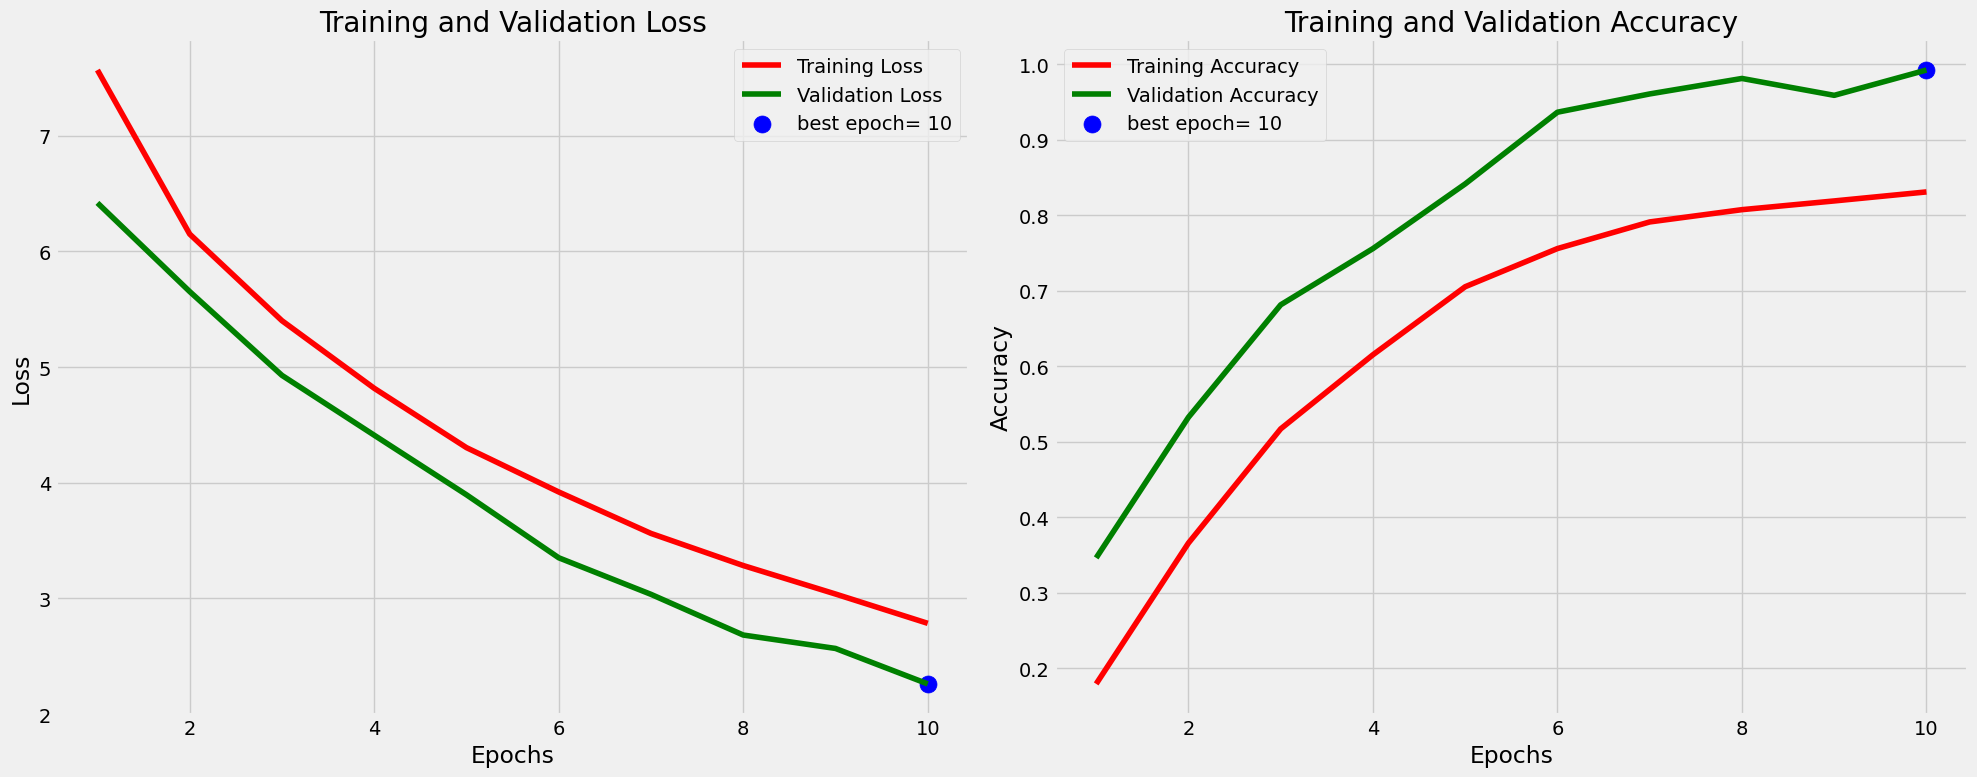

In [ ]:
plot_history(efficientnet_history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = efficientNet_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = efficientNet_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = efficientNet_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.8546 - loss: 2.5779  
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9925 - loss: 2.2612    
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.9889 - loss: 2.2570
Train Loss:  2.5789597034454346
Train Accuracy:  0.8538401126861572
--------------------
Validation Loss:  2.261049509048462
Validation Accuracy:  0.9925512075424194
--------------------
Test Loss:  2.2571609020233154
Test Accuracy:  0.9888579249382019


6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step 
Classification Report:

                   precision    recall  f1-score   support

      Astrocitoma       1.00      1.00      1.00        43
        Carcinoma       1.00      1.00      1.00        15
       Ependimoma       1.00      1.00      1.00        13
    Ganglioglioma       1.00      1.00      1.00         4
        Germinoma       1.00      1.00      1.00         8
     Glioblastoma       0.86      1.00      0.92        12
        Granuloma       1.00      1.00      1.00         7
   Meduloblastoma       1.00      1.00      1.00        13
       Meningioma       1.00      0.96      0.98        73
      Neurocitoma       1.00      1.00      1.00        54
Oligodendroglioma       1.00      0.94      0.97        18
         Papiloma       1.00      1.00      1.00        12
       Schwannoma       1.00      1.00      1.00        40
      Tuberculoma       0.78      1.00      0.88         7
          _NORMAL       1.00      1.00      1.00    

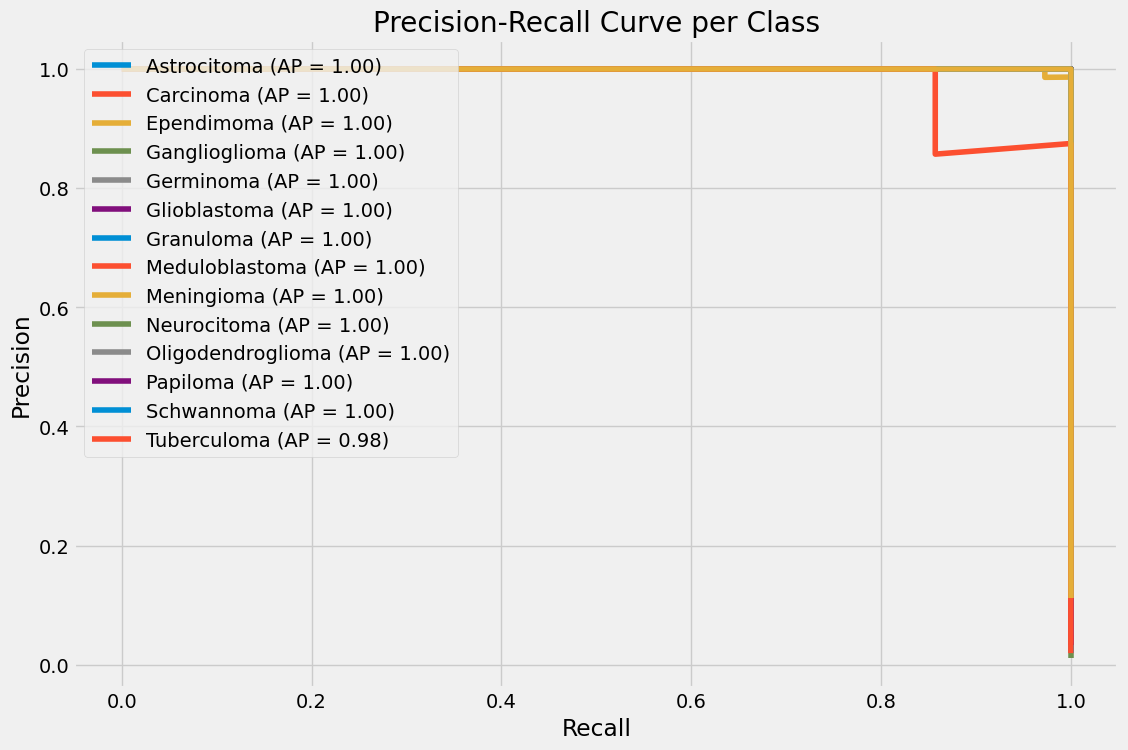

In [ ]:
evaluate_model_performance(efficientNet_model, test_gen)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step


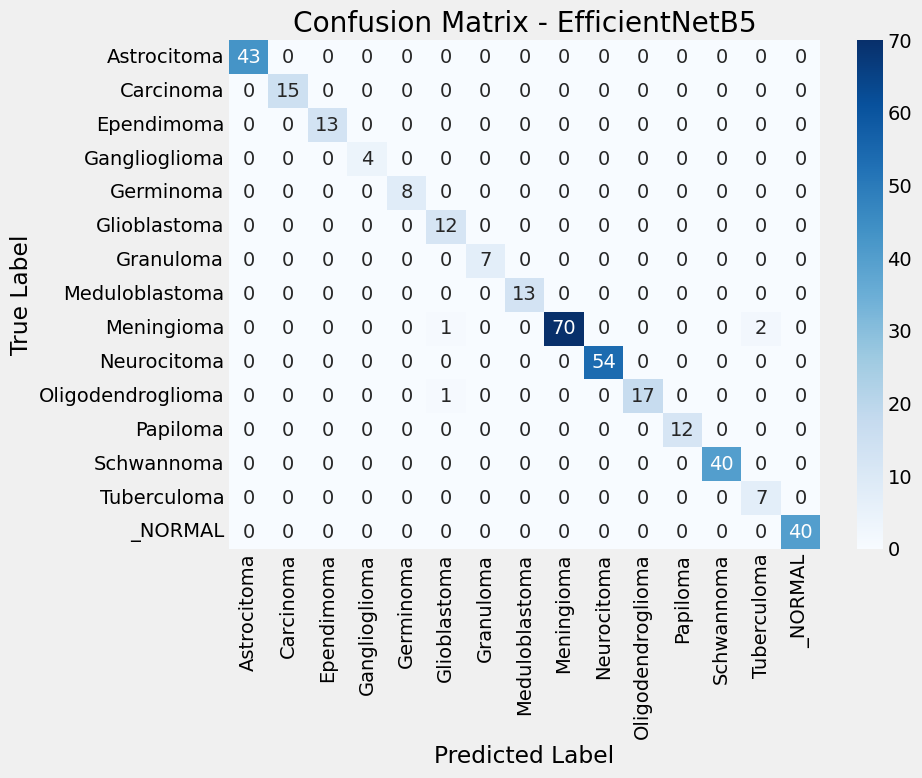

In [ ]:
# Plot confusion matrix for EfficientNetB5
plot_confusion_matrix(efficientNet_model, test_gen, title="Confusion Matrix - EfficientNetB5")



### Model 2 (DenseNet121)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2

# Load the DenseNet121 base model
base_model_d121 = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'  # Global max pooling
)

class_count = len(train_gen.class_indices)

# Build the full model
densenet121_model = Sequential([
    base_model_d121,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(class_count, activation='softmax')  # Output layer
])

# Compile the model
densenet121_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
densenet121_model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,303,759 (27.86 MB)

 Trainable params: 7,220,111 (27.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# Assuming resnet_model is your ResNet50 model and train_gen, valid_gen are your data generators
DenseNet_history = train_model(densenet121_model, train_gen, valid_gen, epochs=20, verbose=1)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.1219 - loss: 10.1555 - val_accuracy: 0.1248 - val_loss: 4.9629 - learning_rate: 0.0010
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.2255 - loss: 4.7854 - val_accuracy: 0.3594 - val_loss: 4.2373 - learning_rate: 0.0010
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.3011 - loss: 4.3133 - val_accuracy: 0.4916 - val_loss: 3.7191 - learning_rate: 0.0010
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.3674 - loss: 4.0055 - val_accuracy: 0.6108 - val_loss: 3.5685 - learning_rate: 0.0010
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.4038 - loss: 3.7939 - val_accuracy: 0.6741 - val_loss: 3.1441 - learning_rate: 0.0010
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.4704 - loss: 3.5220 - val_accuracy: 0.6685 - val_loss: 3.0581 - learning_rate: 0.0010
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.5180 - loss: 3.2

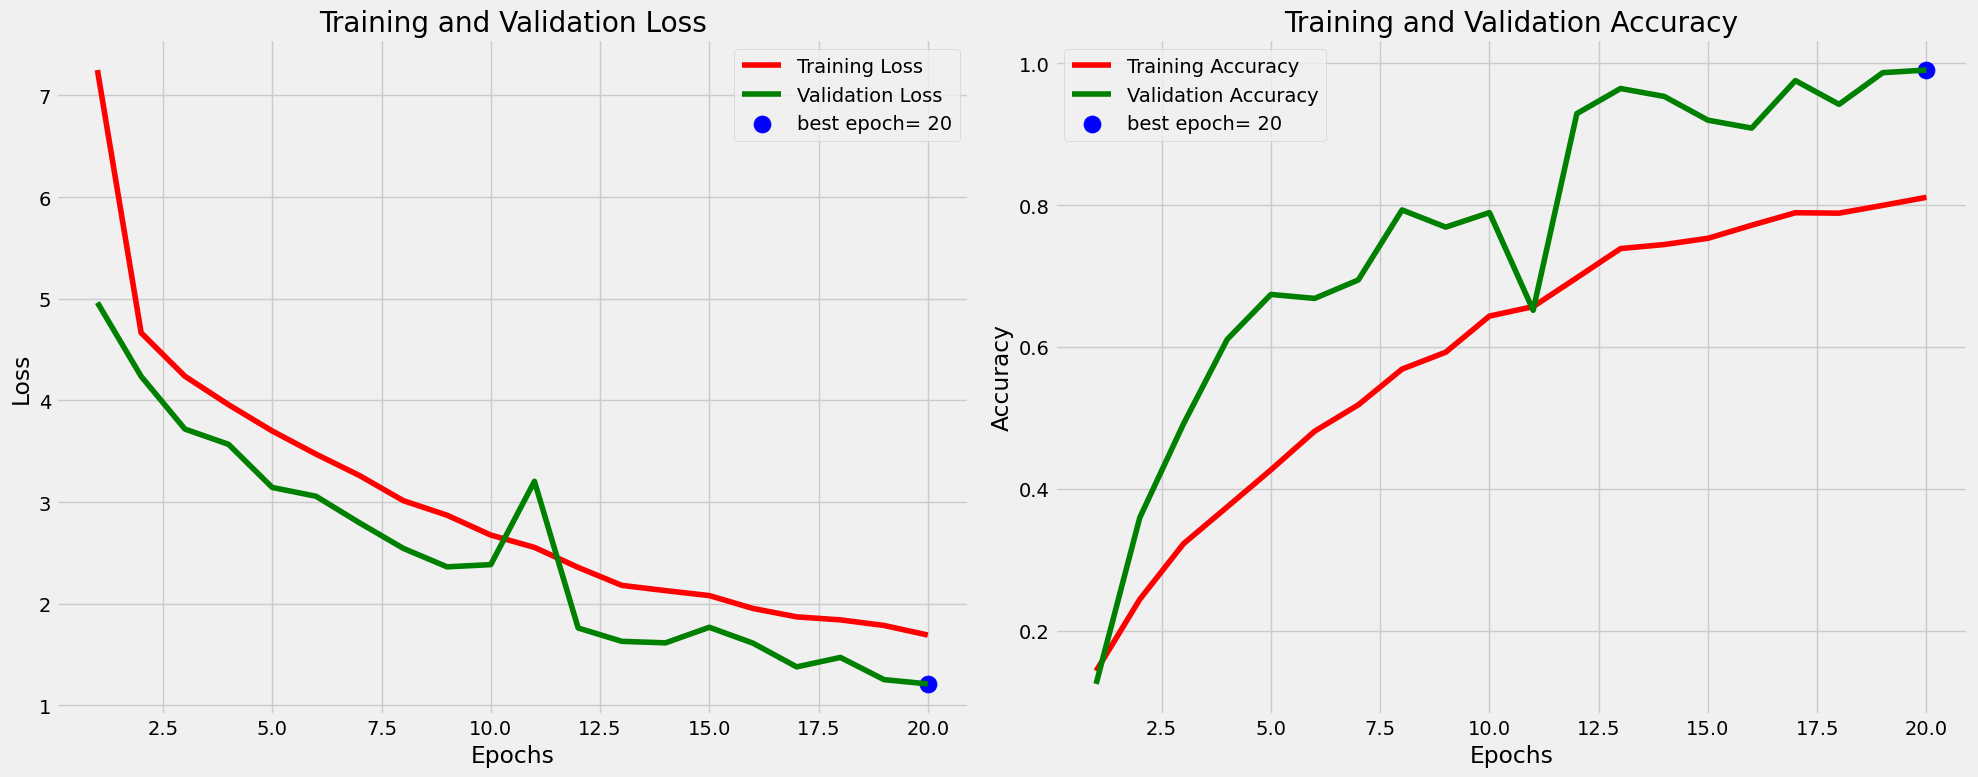

In [ ]:
plot_history(DenseNet_history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step 
Classification Report:

                   precision    recall  f1-score   support

      Astrocitoma       1.00      1.00      1.00        43
        Carcinoma       1.00      1.00      1.00        15
       Ependimoma       0.87      1.00      0.93        13
    Ganglioglioma       1.00      1.00      1.00         4
        Germinoma       1.00      1.00      1.00         8
     Glioblastoma       1.00      1.00      1.00        12
        Granuloma       1.00      0.71      0.83         7
   Meduloblastoma       1.00      1.00      1.00        13
       Meningioma       1.00      1.00      1.00        73
      Neurocitoma       1.00      0.96      0.98        54
Oligodendroglioma       0.95      1.00      0.97        18
         Papiloma       1.00      1.00      1.00        12
       Schwannoma       0.98      1.00      0.99        40
      Tuberculoma       1.00      1.00      1.00         7
          _NORMAL       1.00      1.00      1.00    

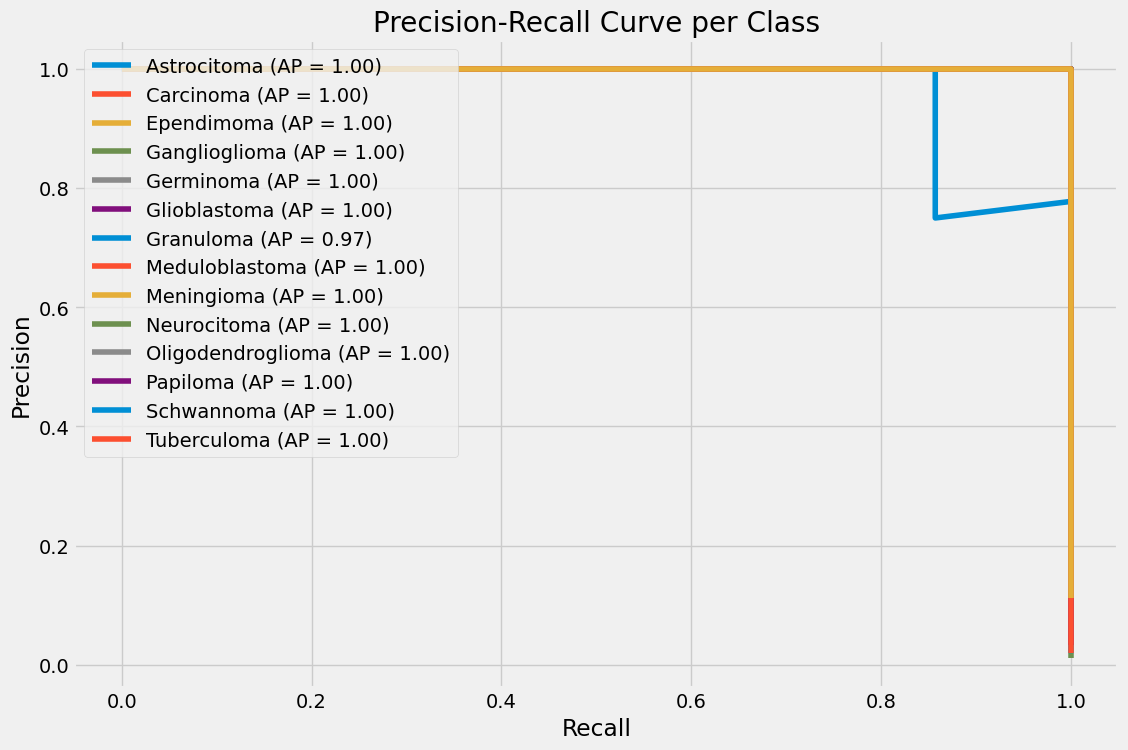

In [ ]:
evaluate_model_performance(densenet121_model, test_gen)


In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = densenet121_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = densenet121_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = densenet121_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

359/359 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.8469 - loss: 1.5586  
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9907 - loss: 1.2121    
359/359 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9887 - loss: 1.2217
Train Loss:  1.5595369338989258
Train Accuracy:  0.846394956111908
--------------------
Validation Loss:  1.2121323347091675
Validation Accuracy:  0.9906890392303467
--------------------
Test Loss:  1.2215332984924316
Test Accuracy:  0.9888579249382019


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


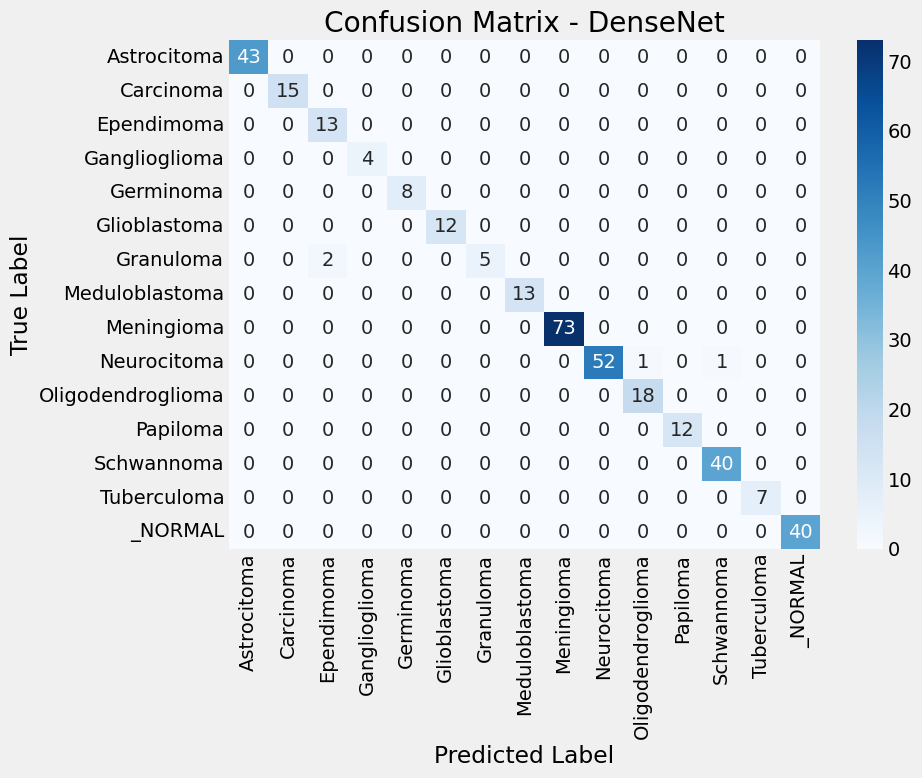

In [ ]:
# Plot confusion matrix for ResNet50
plot_confusion_matrix(densenet121_model, test_gen, title="Confusion Matrix - DenseNet")

### Model 3 (custom model)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
# Callbacks for initial "Before" training
early_stopping_before = EarlyStopping(monitor='val_accuracy',
                                      patience=15, # Adjust as needed
                                      restore_best_weights=True,
                                      verbose=1)

reduce_lr_before = ReduceLROnPlateau(monitor='val_loss',
                                     factor=0.2,
                                     patience=7, # Adjust as needed
                                     min_lr=0.00001,
                                     verbose=1)

# Callbacks for "After" training (can be the same or adjusted)
early_stopping_after = EarlyStopping(monitor='val_accuracy',
                                     patience=20, # Potentially more patience for the tuned model
                                     restore_best_weights=True,
                                     verbose=1)

reduce_lr_after = ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.2,
                                    patience=10, # Potentially more patience
                                    min_lr=0.000001,
                                    verbose=1)

# Callback for tuner search (can be different, often more aggressive early stopping)
early_stopping_tuner = EarlyStopping(monitor='val_accuracy',
                                     patience=10, # Stricter patience for faster trials
                                     restore_best_weights=True, # Important for tuner
                                     verbose=1)
reduce_lr_tuner = ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.2,
                                    patience=5,
                                    min_lr=0.00001,
                                    verbose=1)




class_count = len(train_gen.class_indices)

baseline_model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), padding='same', input_shape=img_shape),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2),

    # Block 2
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2),

    # Block 3
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(class_count, activation='softmax')
])

# Moderate LR Adam tends to converge fast but not overshoot
baseline_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,439 (1.55 MB)

 Trainable params: 406,543 (1.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Assuming resnet_model is your ResNet50 model and train_gen, valid_gen are your data generators
Custom_history = train_model(baseline_model, train_gen, valid_gen, epochs=10, verbose=1)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 417ms/step - accuracy: 0.1148 - loss: 2.8601 - val_accuracy: 0.1006 - val_loss: 2.9014 - learning_rate: 1.0000e-04
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.2092 - loss: 2.5113 - val_accuracy: 0.1899 - val_loss: 2.5038 - learning_rate: 1.0000e-04
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.2371 - loss: 2.4616 - val_accuracy: 0.2160 - val_loss: 2.4352 - learning_rate: 1.0000e-04
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.2503 - loss: 2.4334 - val_accuracy: 0.2402 - val_loss: 2.3541 - learning_rate: 1.0000e-04
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - accuracy: 0.2753 - loss: 2.3489 - val_accuracy: 0.2495 - val_loss: 2.3194 - learning_rate: 1.0000e-04
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.2936 - loss: 2.3281 - val_accuracy: 0.2868 - val_loss: 2.3444 - learning_rate: 1.0000e-04
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 722ms/step
Classification Report:

                   precision    recall  f1-score   support

      Astrocitoma       0.33      0.35      0.34        43
        Carcinoma       0.30      0.87      0.44        15
       Ependimoma       0.00      0.00      0.00        13
    Ganglioglioma       0.00      0.00      0.00         4
        Germinoma       0.00      0.00      0.00         8
     Glioblastoma       0.00      0.00      0.00        12
        Granuloma       1.00      0.14      0.25         7
   Meduloblastoma       1.00      0.15      0.27        13
       Meningioma       0.38      0.38      0.38        73
      Neurocitoma       0.44      0.57      0.50        54
Oligodendroglioma       1.00      0.06      0.11        18
         Papiloma       0.00      0.00      0.00        12
       Schwannoma       0.58      0.62      0.60        40
      Tuberculoma       0.33      0.14      0.20         7
          _NORMAL       0.47      0.85      0.60   

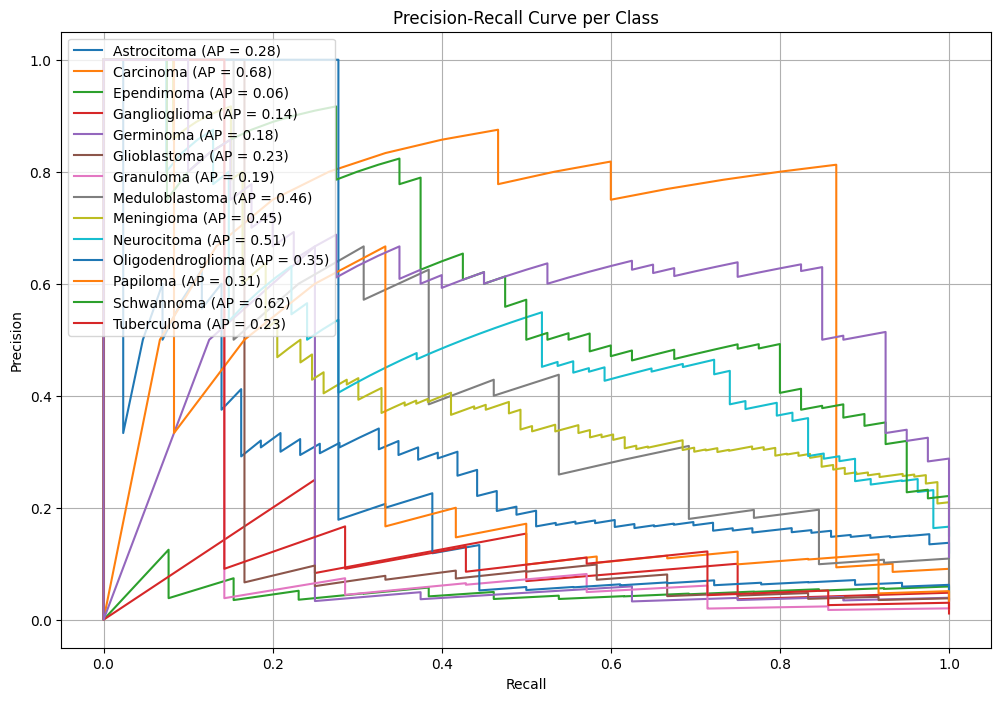

In [ ]:
evaluate_model_performance(baseline_model, test_gen)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = baseline_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = baseline_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = baseline_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
# Plot confusion matrix for ResNet50
plot_confusion_matrix(baseline_model, test_gen, title="Confusion Matrix - Custom Model")

## Hyperparameter Tuning (on the custom model)

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
# ...existing code...
# Make sure keras-tuner is installed
# !pip install -q keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2 # If you want to tune regularization

# Ensure img_shape and class_count are defined from previous cells
# Example: img_shape = (224, 224, 3)
# Example: class_count = train_gen.num_classes

def build_custom_model_tuner(hp):
    model = Sequential()

    # Block 1
    model.add(Conv2D(
        filters=hp.Int('filters_block1', min_value=32, max_value=96, step=32), # e.g., 32, 64, 96
        kernel_size=(3, 3),
        padding='same',
        input_shape=img_shape
    ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2))

    # Block 2
    model.add(Conv2D(
        filters=hp.Int('filters_block2', min_value=64, max_value=192, step=64), # e.g., 64, 128, 192
        kernel_size=(3, 3),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2))

    # Block 3
    model.add(Conv2D(
        filters=hp.Int('filters_block3', min_value=128, max_value=384, step=128), # e.g., 128, 256, 384
        kernel_size=(3, 3),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(2))

    model.add(GlobalAveragePooling2D())

    # Dense Layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64), # e.g., 64, 128, 192, 256
        activation='relu'
    ))
    model.add(Dropout(
        rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1) # e.g., 0.2, 0.3, 0.4, 0.5
    ))

    model.add(Dense(class_count, activation='softmax'))

    # Tune the learning rate for Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4, 5e-5])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the tuner
tuner_custom_model = kt.RandomSearch(
    build_custom_model_tuner,
    objective='val_accuracy',
    max_trials=15,  # Number of hyperparameter combinations to try
    executions_per_trial=1, # How many models to build and train for each trial
    directory='custom_model_tuning',
    project_name='brain_tumor_custom_cnn'
)

# Define a callback to stop training early if validation loss doesn't improve
# This helps speed up the search by pruning unpromising trials
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3, # Stop after 3 epochs of no improvement in val_loss
    restore_best_weights=True
)

print("Starting hyperparameter search for the custom model...")
# Each trial will run for a limited number of epochs to save time
# Given 1 epoch ~21s, 5 epochs/trial * 15 trials ~ 26 minutes.
# This should fit within the 40-minute budget, including overhead.
tuner_custom_model.search(
    train_gen,
    epochs=7, # Max epochs to train each model configuration during search
    validation_data=valid_gen,
    callbacks=[early_stopping_callback],
    verbose=1
)

# Get the optimal hyperparameters
best_hps_custom = tuner_custom_model.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters for the first convolutional block is {best_hps_custom.get('filters_block1')},
for the second block is {best_hps_custom.get('filters_block2')}, and for the third block is {best_hps_custom.get('filters_block3')}.
The optimal number of units in the dense layer is {best_hps_custom.get('dense_units')}.
The optimal dropout rate is {best_hps_custom.get('dropout_rate')}.
The optimal learning rate for the optimizer is {best_hps_custom.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters
best_custom_model = tuner_custom_model.hypermodel.build(best_hps_custom)


Reloading Tuner from custom_model_tuning/brain_tumor_custom_cnn/tuner0.json
Starting hyperparameter search for the custom model...

The hyperparameter search is complete. The optimal number of filters for the first convolutional block is 32,
for the second block is 64, and for the third block is 256.
The optimal number of units in the dense layer is 192.
The optimal dropout rate is 0.2.
The optimal learning rate for the optimizer is 0.0005.



In [ ]:
# Assuming resnet_model is your ResNet50 model and train_gen, valid_gen are your data generators
best_custom_model_history = train_model(best_custom_model, train_gen, valid_gen, epochs=20, verbose=1)

Epoch 1/20


80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 300ms/step - accuracy: 0.1844 - loss: 2.5413 - val_accuracy: 0.1117 - val_loss: 2.6027 - learning_rate: 5.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - accuracy: 0.2794 - loss: 2.3019 - val_accuracy: 0.1341 - val_loss: 2.6843 - learning_rate: 5.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.3223 - loss: 2.1721 - val_accuracy: 0.1378 - val_loss: 2.6119 - learning_rate: 5.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.3451 - loss: 2.0966 - val_accuracy: 0.3352 - val_loss: 2.0854 - learning_rate: 2.5000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.3661 - loss: 2.0485 - val_accuracy: 0.3762 - val_loss: 2.0612 - learning_rate: 2.5000e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.3823 - loss: 1.9965 - val_accuracy: 0.3948 - val_loss: 1.8803 - learning_rate: 2.5000e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.40

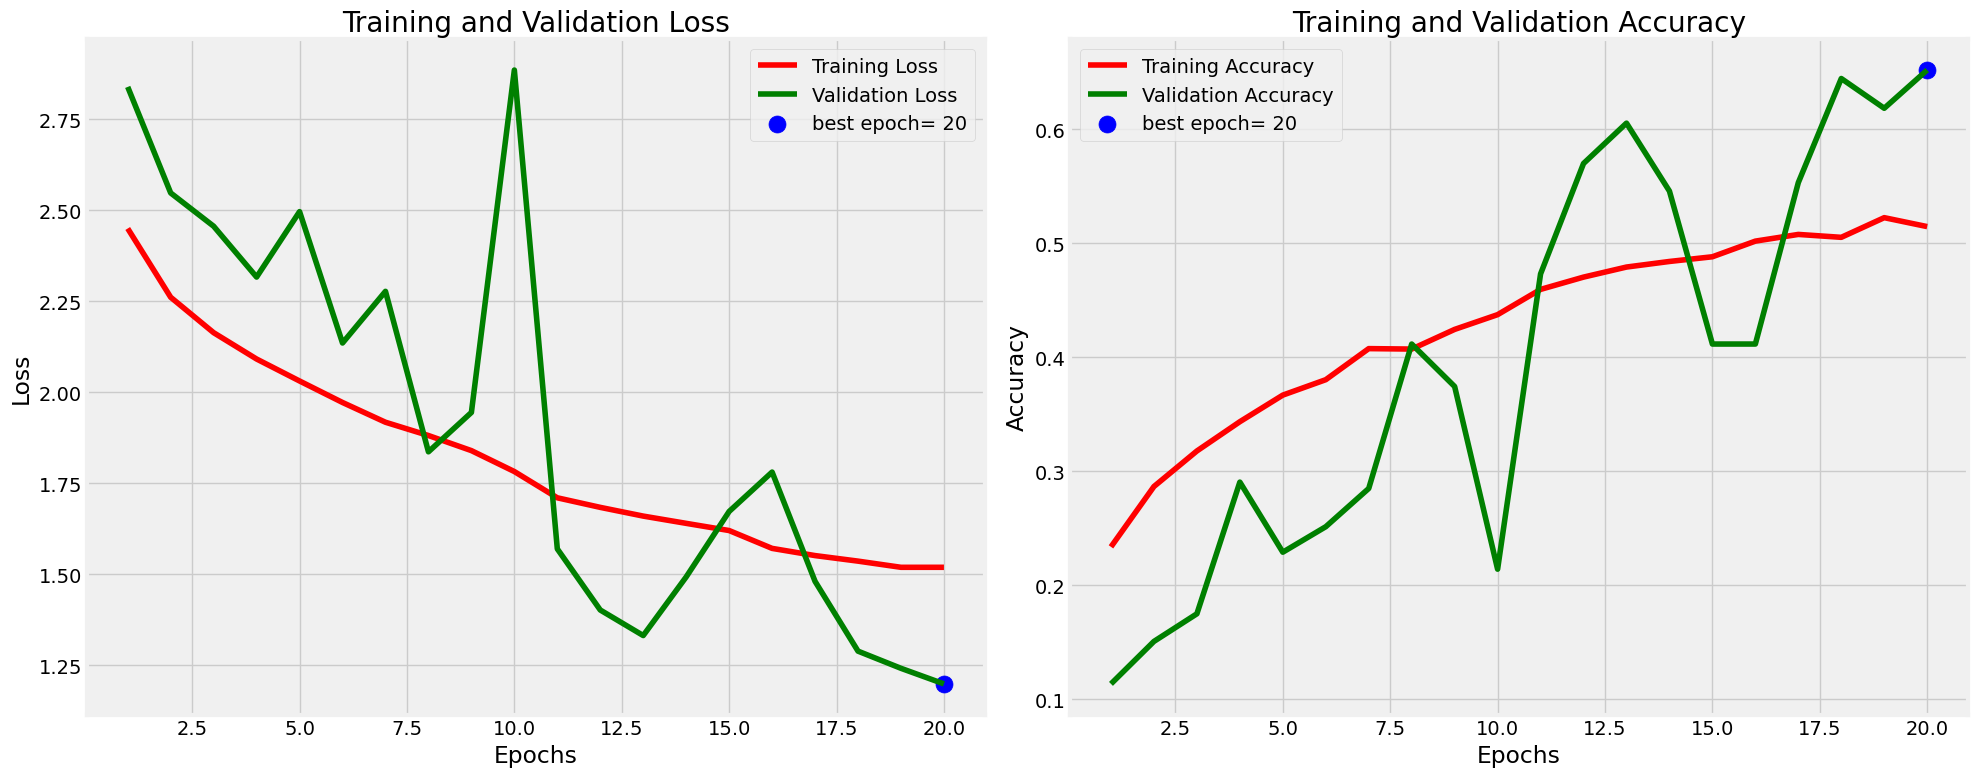

In [ ]:
plot_history(best_custom_model_history)


In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = best_custom_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = best_custom_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = best_custom_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4303 - loss: 1.8201  
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5359 - loss: 1.4974    
359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5100 - loss: 1.5540   
Train Loss:  1.8190560340881348
Train Accuracy:  0.4296630024909973
--------------------
Validation Loss:  1.5000194311141968
Validation Accuracy:  0.5344506502151489
--------------------
Test Loss:  1.5544636249542236
Test Accuracy:  0.5097492933273315


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step


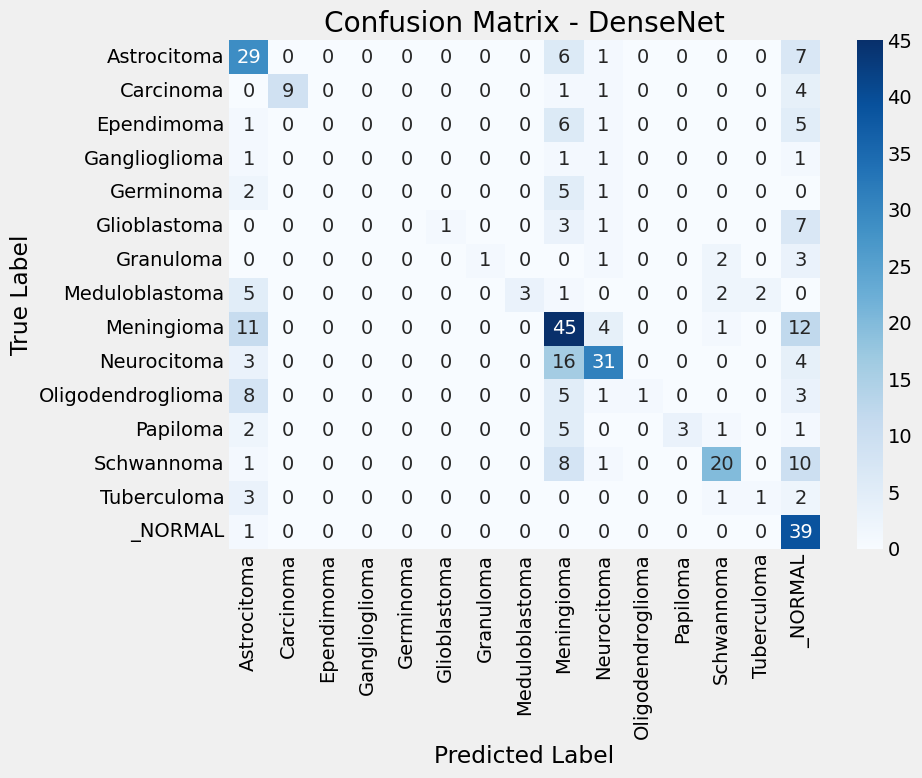

In [ ]:
# Plot confusion matrix for ResNet50
plot_confusion_matrix(best_custom_model, test_gen, title="Confusion Matrix - DenseNet")

### Comparison: Custom Model Before vs. After Hyperparameter Tuning

Evaluating Custom Model (Before Tuning) on Test Data:
  Test Loss (Before Tuning): 2.0030
  Test Accuracy (Before Tuning): 0.4206

Evaluating Tuned Custom Model (After Tuning) on Test Data:
  Test Loss (After Tuning): 1.5545
  Test Accuracy (After Tuning): 0.5097

--- Comparison Summary ---
Custom Model (Before Tuning): Test Loss = 2.0030, Test Accuracy = 0.4206
Tuned Custom Model (After Tuning): Test Loss = 1.5545, Test Accuracy = 0.5097

Improvement in Test Accuracy: 0.0891 (8.91%)
Change in Test Loss: -0.4485


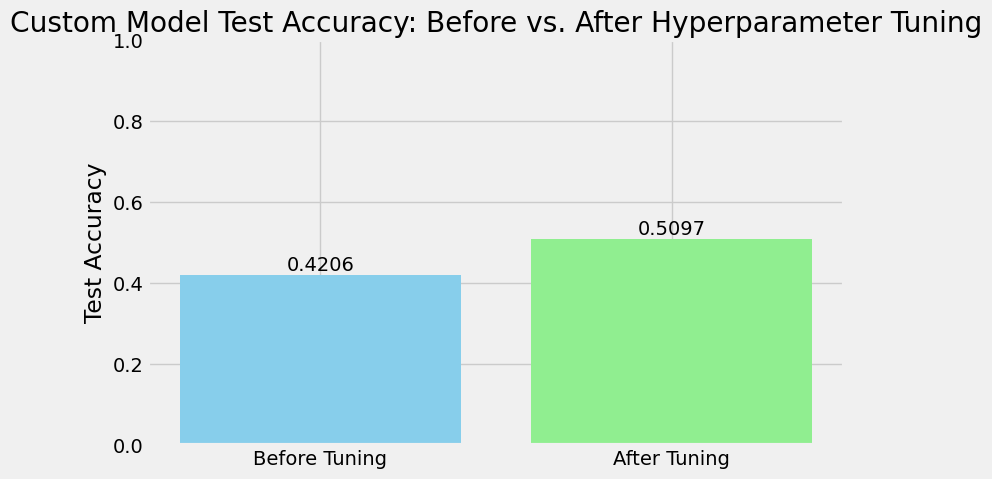

In [ ]:
print("Evaluating Custom Model (Before Tuning) on Test Data:")
# Ensure baseline_model is the trained model object, not its history
# If you have overwritten baseline_model with its history, you might need to reload or retrain it
# For this example, we assume baseline_model is the trained Keras model object.
try:
    # Re-evaluate if not stored, or use stored scores if available and reliable
    # It's generally safer to re-evaluate to ensure consistency
    loss_before, acc_before = baseline_model.evaluate(test_gen, steps=test_steps, verbose=0)
    print(f"  Test Loss (Before Tuning): {loss_before:.4f}")
    print(f"  Test Accuracy (Before Tuning): {acc_before:.4f}")
except Exception as e:
    print(f"Could not evaluate baseline_model. Ensure it's a trained Keras model. Error: {e}")
    print("You might need to re-run the training cell for 'baseline_model' if it was overwritten.")
    acc_before, loss_before = None, None # Fallback values

print("\nEvaluating Tuned Custom Model (After Tuning) on Test Data:")
# Ensure best_custom_model is the trained model object
try:
    loss_after, acc_after = best_custom_model.evaluate(test_gen, steps=test_steps, verbose=0)
    print(f"  Test Loss (After Tuning): {loss_after:.4f}")
    print(f"  Test Accuracy (After Tuning): {acc_after:.4f}")
except Exception as e:
    print(f"Could not evaluate best_custom_model. Ensure it's a trained Keras model. Error: {e}")
    acc_after, loss_after = None, None # Fallback values

print("\n--- Comparison Summary ---")
if loss_before is not None and acc_before is not None:
    print(f"Custom Model (Before Tuning): Test Loss = {loss_before:.4f}, Test Accuracy = {acc_before:.4f}")
else:
    print("Custom Model (Before Tuning): Evaluation data not available.")

if loss_after is not None and acc_after is not None:
    print(f"Tuned Custom Model (After Tuning): Test Loss = {loss_after:.4f}, Test Accuracy = {acc_after:.4f}")
else:
    print("Tuned Custom Model (After Tuning): Evaluation data not available.")

if acc_before is not None and acc_after is not None:
    accuracy_improvement = acc_after - acc_before
    print(f"\nImprovement in Test Accuracy: {accuracy_improvement:.4f} ({accuracy_improvement*100:.2f}%)")
if loss_before is not None and loss_after is not None:
    loss_change = loss_after - loss_before
    print(f"Change in Test Loss: {loss_change:.4f}")

# You can also create a bar plot for visual comparison if desired
if acc_before is not None and acc_after is not None:
    labels = ['Before Tuning', 'After Tuning']
    accuracies = [acc_before, acc_after]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, accuracies, color=['skyblue', 'lightgreen'])
    plt.ylabel('Test Accuracy')
    plt.title('Custom Model Test Accuracy: Before vs. After Hyperparameter Tuning')
    plt.ylim([min(0, min(accuracies) - 0.05), max(1, max(accuracies) + 0.05)]) # Adjust y-limits
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", color='black', ha='center')
    plt.show()

## 5. Testing using a different dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


Processing new dataset for visualization and later evaluation...
Path to new dataset files (should be defined in a previous cell): /kaggle/input/brain-tumor-mri-dataset
Original training class indices (from train_gen): {'Astrocitoma': 0, 'Carcinoma': 1, 'Ependimoma': 2, 'Ganglioglioma': 3, 'Germinoma': 4, 'Glioblastoma': 5, 'Granuloma': 6, 'Meduloblastoma': 7, 'Meningioma': 8, 'Neurocitoma': 9, 'Oligodendroglioma': 10, 'Papiloma': 11, 'Schwannoma': 12, 'Tuberculoma': 13, '_NORMAL': 14}



New mapped dataset DataFrame head:
                                           filepaths   labels
0  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL
1  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL
2  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL
3  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL
4  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL

New mapped dataset class counts:
labels
_NORMAL         2000
Meningioma      1645
Glioblastoma    1621
Name: count, dtype: int64

Visualizing new mapped dataset class distribution:


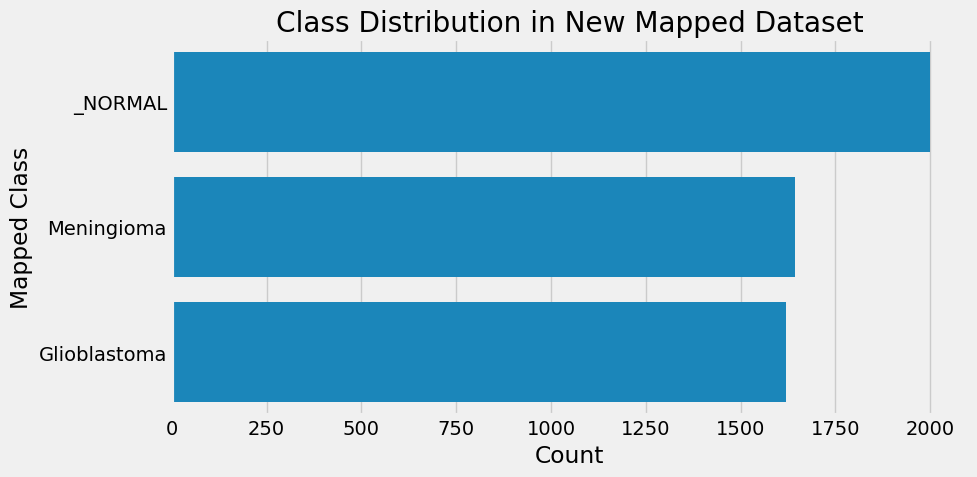


Displaying sample images from new mapped dataset:


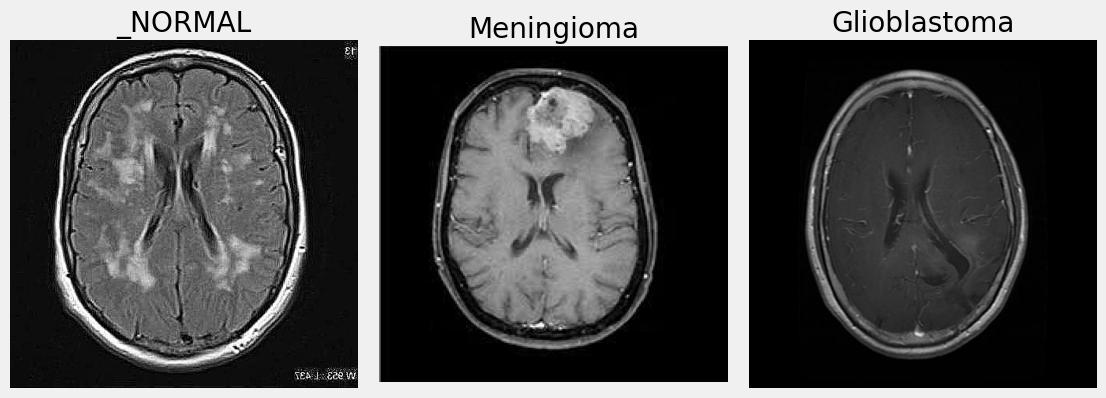


Finished processing and visualizing new dataset.


In [ ]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image # Ensure PIL is imported if not already globally available from c665666f

# Ensure 'path' (from cell 1dba884c) and 'train_gen' (from cell db4aa96a) are defined and available
# by running those cells before this one.

print("Processing new dataset for visualization and later evaluation...")
print("Path to new dataset files (should be defined in a previous cell):", path)

filepaths_new = []
labels_new = []

# --- CRITICAL: USER MUST DEFINE THIS MAPPING ---
# Map new dataset folder names to the EXACT class names used when training the original models
# (i.e., keys in `train_gen.class_indices` from your original training setup).
new_to_original_label_map = {
    'glioma': 'Glioblastoma',
    'meningioma': 'Meningioma',
    'notumor': '_NORMAL',
    'pituitary': 'Pituitary' # This class will be skipped if 'Pituitary' is not in original_training_class_indices
}
# --- END OF USER DEFINED MAPPING ---

# Get the class_indices from the original training generator.
original_training_class_indices = train_gen.class_indices
print(f"Original training class indices (from train_gen): {original_training_class_indices}")

# Iterate through 'Training' and 'Testing' subdirectories of the new dataset
for sub_dir_name in ['Training', 'Testing']:
    sub_dir_path = os.path.join(path, sub_dir_name)
    if not os.path.isdir(sub_dir_path):
        print(f"Info: Subdirectory '{sub_dir_path}' not found in new dataset, skipping.")
        continue

    for class_folder_name_new_dataset in os.listdir(sub_dir_path):
        class_path_new_dataset = os.path.join(sub_dir_path, class_folder_name_new_dataset)

        if os.path.isdir(class_path_new_dataset):
            original_model_class_name = new_to_original_label_map.get(class_folder_name_new_dataset)

            if original_model_class_name and original_model_class_name in original_training_class_indices:
                for image_file_name in os.listdir(class_path_new_dataset):
                    image_file_path = os.path.join(class_path_new_dataset, image_file_name)
                    if os.path.isfile(image_file_path) and image_file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        filepaths_new.append(image_file_path)
                        labels_new.append(original_model_class_name)
            elif original_model_class_name:
                print(f"Warning: Mapped class '{original_model_class_name}' (from new dataset folder '{class_folder_name_new_dataset}') is not in original training classes. Skipping this class.")
            else:
                print(f"Warning: Class folder '{class_folder_name_new_dataset}' from new dataset has no mapping. Skipping this class.")

if not filepaths_new:
    print("ERROR: No image files found or mapped from the new dataset. Evaluation cannot proceed.")
    df_new = pd.DataFrame({'filepaths': [], 'labels': []})
else:
    Fseries_new = pd.Series(filepaths_new, name='filepaths')
    Lseries_new = pd.Series(labels_new, name='labels')
    df_new = pd.concat([Fseries_new, Lseries_new], axis=1)

    print("\nNew mapped dataset DataFrame head:")
    print(df_new.head())
    print("\nNew mapped dataset class counts:")
    print(df_new['labels'].value_counts())

    # --- START: Visualizations for the new dataset ---
    if not df_new.empty and not df_new['labels'].empty:
        print("\nVisualizing new mapped dataset class distribution:")
        plt.figure(figsize=(10, 5))
        sns.countplot(y=df_new['labels'], order=df_new['labels'].value_counts().index)
        plt.title('Class Distribution in New Mapped Dataset')
        plt.xlabel('Count')
        plt.ylabel('Mapped Class')
        plt.tight_layout()
        plt.show()

        print("\nDisplaying sample images from new mapped dataset:")
        mapped_classes_present = df_new['labels'].unique()
        num_classes_to_show = len(mapped_classes_present)

        if num_classes_to_show > 0:
            num_cols = 4
            num_rows = (num_classes_to_show + num_cols - 1) // num_cols
            plt.figure(figsize=(15, num_rows * 4))
            for i, class_name in enumerate(mapped_classes_present):
                sample_df = df_new[df_new['labels'] == class_name].sample(1, random_state=123)
                if not sample_df.empty:
                    img_path = sample_df['filepaths'].iloc[0]
                    try:
                        img_pil = Image.open(img_path)
                        img_np = np.array(img_pil)

                        # Ensure image is RGB (discard alpha channel if present)
                        if img_np.ndim == 3 and img_np.shape[2] == 4:
                            img_np = img_np[..., :3]

                        # Handle grayscale images by converting to RGB for consistent display
                        # and to prevent imshow errors if other images are RGB.
                        if img_np.ndim == 2:
                            # Convert grayscale to RGB by duplicating the channel
                            img_np = np.stack((img_np,)*3, axis=-1)

                        # Normalize to [0,1] for display if image pixel values are likely in [0,255] range
                        # This makes this plot's display scale similar to the original dataset's sample plot (cell 8e1828f8)
                        display_img = img_np.astype(np.float32) # Convert to float for division
                        if np.max(display_img) > 1.0: # Heuristic: if max val > 1, assume it's [0,255]
                            display_img = display_img / 255.0

                        plt.subplot(num_rows, num_cols, i + 1)
                        plt.imshow(display_img)
                        plt.title(class_name)
                        plt.axis('off')
                    except Exception as e:
                        print(f"Could not load image {img_path} for class {class_name}: {e}")
            plt.tight_layout()
            plt.show()
        else:
            print("No classes with images found in df_new to display for visualization.")
    else:
        print("df_new is empty, skipping visualizations for the new dataset.")
    # --- END: Visualizations for the new dataset ---

print("\nFinished processing and visualizing new dataset.")

Comparing sample images from original test_gen and new test_gen_new


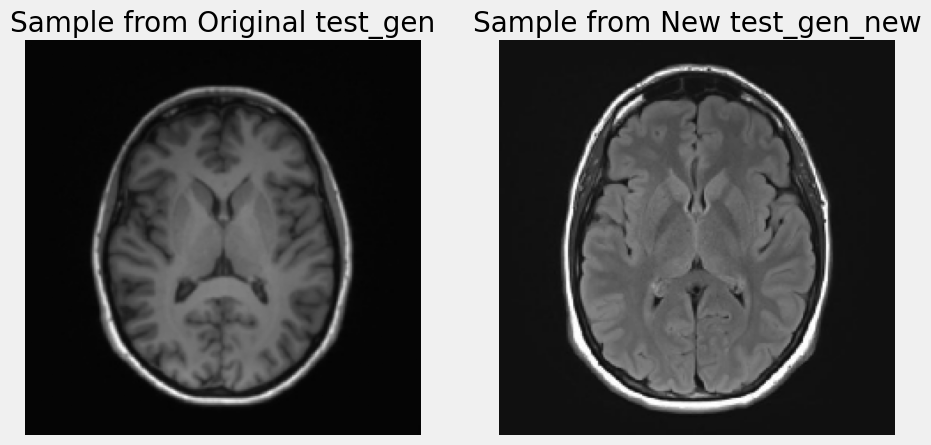

In [ ]:
# Optional: New cell after d92e2f73 to compare generator outputs

if 'test_gen' in globals() and 'test_gen_new' in globals() and test_gen_new is not None:
    print("Comparing sample images from original test_gen and new test_gen_new")

    # Get a batch from the original test generator
    try:
        original_images, original_labels = next(iter(test_gen)) # iter() is safer if generator could be exhausted
        img_original_sample = original_images[0]
        # If original generator outputs [0,255], imshow handles it or you can scale to [0,1]
        # Assuming no rescale in generator, so images are [0,255]
        if np.max(img_original_sample) > 1.0:
             img_original_sample_display = img_original_sample / 255.0
        else:
             img_original_sample_display = img_original_sample

    except StopIteration:
        print("Could not get a batch from original test_gen.")
        img_original_sample_display = None
    except Exception as e:
        print(f"Error getting sample from original test_gen: {e}")
        img_original_sample_display = None

    # Get a batch from the new test generator
    try:
        new_images, new_labels = next(iter(test_gen_new))
        img_new_sample = new_images[0]
        # Assuming no rescale in generator, so images are [0,255]
        if np.max(img_new_sample) > 1.0:
            img_new_sample_display = img_new_sample / 255.0
        else:
            img_new_sample_display = img_new_sample

    except StopIteration:
        print("Could not get a batch from new test_gen_new.")
        img_new_sample_display = None
    except Exception as e:
        print(f"Error getting sample from new test_gen_new: {e}")
        img_new_sample_display = None

    # Plot them
    if img_original_sample_display is not None or img_new_sample_display is not None:
        plt.figure(figsize=(10, 5))
        if img_original_sample_display is not None:
            plt.subplot(1, 2, 1)
            plt.imshow(img_original_sample_display)
            plt.title("Sample from Original test_gen")
            plt.axis('off')

        if img_new_sample_display is not None:
            plt.subplot(1, 2, 2)
            plt.imshow(img_new_sample_display)
            plt.title("Sample from New test_gen_new")
            plt.axis('off')
        plt.show()
    else:
        print("No samples to display from generators.")

else:
    print("Skipping generator output comparison: test_gen or test_gen_new not available.")

In [ ]:
# ...existing code in cell b5cc5798...

def evaluate_model_performance_on_subset(model, test_gen_subset, original_class_indices):
    """
    Evaluates model performance on a subset of classes present in test_gen_subset,
    aligning predictions with the original model's full class set.
    """
    y_true_subset_indices = test_gen_subset.classes
    y_pred_probs_subset = model.predict(test_gen_subset, steps=np.ceil(test_gen_subset.samples / test_gen_subset.batch_size).astype(int))
    # y_pred_probs_subset will have shape (num_samples_in_subset, num_original_classes)
    # because test_gen_subset was created with `classes=list(original_class_indices.keys())`

    # Get predicted class indices based on the original model's output layer
    y_pred_subset_indices = np.argmax(y_pred_probs_subset, axis=1)

    # Get the names of all original classes
    original_class_labels_list = list(original_class_indices.keys())

    # Get the names of classes actually present in the subset generator
    # These are the labels we care about for the report.
    # We need their corresponding indices from the *original* class mapping.
    subset_class_names_present = [original_class_labels_list[i] for i in sorted(np.unique(y_true_subset_indices))]

    print("Classification Report (on new dataset subset, aligned with original classes):\n")
    # For classification_report, target_names should correspond to the unique sorted labels in y_true and y_pred
    # We need to ensure y_true_subset_indices and y_pred_subset_indices are correctly aligned for the classes present.

    # Filter y_pred_probs_subset to only include probabilities for classes present in the subset,
    # then re-normalize or simply use argmax on the full probabilities if the model handles it.
    # The current y_pred_subset_indices are already aligned with original_class_indices.

    # We need to report based on the classes *present* in test_gen_subset.
    # The y_true_subset_indices are already correct for this.
    # The y_pred_subset_indices are also based on the full model output.

    # Get the integer labels for the classes present in the subset, according to original_class_indices
    labels_for_report = sorted(np.unique(y_true_subset_indices)) # These are the integer indices

    print(classification_report(y_true_subset_indices, y_pred_subset_indices, labels=labels_for_report, target_names=subset_class_names_present, zero_division=0))

    precision = precision_score(y_true_subset_indices, y_pred_subset_indices, average='macro', labels=labels_for_report, zero_division=0)
    recall = recall_score(y_true_subset_indices, y_pred_subset_indices, average='macro', labels=labels_for_report, zero_division=0)
    f1 = f1_score(y_true_subset_indices, y_pred_subset_indices, average='macro', labels=labels_for_report, zero_division=0)

    print(f"Macro Precision (for subset classes): {precision:.4f}")
    print(f"Macro Recall (for subset classes): {recall:.4f}")
    print(f"Macro F1 Score (for subset classes): {f1:.4f}")

    # Binarize true labels for multi-class ROC and PR curves, considering only subset classes
    # Map y_true_subset_indices to a local 0-to-N-1 range for binarization if needed,
    # or ensure y_true_bin and y_pred_probs_subset are aligned.

    # For PR curves, we need to iterate through the classes *present* in the subset.
    y_true_bin_subset = label_binarize(y_true_subset_indices, classes=labels_for_report) # Binarize against the present classes

    # We need to select the corresponding columns from y_pred_probs_subset
    # y_pred_probs_subset has columns for *all* original classes.
    # We only want the columns corresponding to `labels_for_report`.
    y_pred_probs_for_subset_classes = y_pred_probs_subset[:, labels_for_report]


    if y_true_bin_subset.shape[1] == 0: # No classes to plot
        print("No classes present in the subset to plot PR curves for.")
        return

    precision_dict, recall_dict, pr_auc = {}, {}, {}
    plt.figure(figsize=(12, 8))

    # Iterate using the local indices (0 to num_subset_classes-1) for y_true_bin_subset and y_pred_probs_for_subset_classes
    for i in range(y_true_bin_subset.shape[1]):
        class_original_index = labels_for_report[i] # Original index of this class
        class_name = original_class_labels_list[class_original_index] # Name of this class

        precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_true_bin_subset[:, i], y_pred_probs_for_subset_classes[:, i])
        pr_auc[i] = average_precision_score(y_true_bin_subset[:, i], y_pred_probs_for_subset_classes[:, i])
        plt.plot(recall_dict[i], precision_dict[i], label=f'{class_name} (AP = {pr_auc[i]:.2f})')

    plt.title('Precision-Recall Curve per Class (New Dataset Subset)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if y_true_bin_subset.shape[1] > 0 : plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def plot_confusion_matrix_on_subset(model, test_gen_subset, original_class_indices, title="Confusion Matrix (New Dataset Subset)"):
    """
    Plots a confusion matrix for a model on a subset of classes,
    aligning predictions with the original model's full class set.
    """
    y_true_subset_indices = test_gen_subset.classes # These are indices relative to original_class_indices
    y_pred_probs_subset = model.predict(test_gen_subset, steps=np.ceil(test_gen_subset.samples / test_gen_subset.batch_size).astype(int))
    y_pred_subset_indices = np.argmax(y_pred_probs_subset, axis=1) # Indices relative to original_class_indices

    # Get the names of all original classes
    original_class_labels_list = list(original_class_indices.keys())

    # Determine the unique class indices present in the true labels of the subset
    unique_true_indices_in_subset = sorted(np.unique(y_true_subset_indices))

    if not unique_true_indices_in_subset:
        print("No true labels found in the subset generator. Cannot plot confusion matrix.")
        return

    # Create class labels for the confusion matrix based on classes present in the subset's true labels
    cm_class_labels = [original_class_labels_list[i] for i in unique_true_indices_in_subset]

    # Compute confusion matrix using the unique true indices present in the subset for the 'labels' parameter
    cm = confusion_matrix(y_true_subset_indices, y_pred_subset_indices, labels=unique_true_indices_in_subset)

    plt.figure(figsize=(max(8, len(cm_class_labels)), max(6, len(cm_class_labels) * 0.8)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=cm_class_labels,
                yticklabels=cm_class_labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


Path to new dataset files: /kaggle/input/brain-tumor-mri-dataset
Original training class indices (from train_gen): {'Astrocitoma': 0, 'Carcinoma': 1, 'Ependimoma': 2, 'Ganglioglioma': 3, 'Germinoma': 4, 'Glioblastoma': 5, 'Granuloma': 6, 'Meduloblastoma': 7, 'Meningioma': 8, 'Neurocitoma': 9, 'Oligodendroglioma': 10, 'Papiloma': 11, 'Schwannoma': 12, 'Tuberculoma': 13, '_NORMAL': 14}



New mapped dataset DataFrame head:
                                           filepaths   labels
0  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL
1  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL
2  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL
3  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL
4  /kaggle/input/brain-tumor-mri-dataset/Training...  _NORMAL

New mapped dataset class counts:
labels
_NORMAL         2000
Meningioma      1645
Glioblastoma    1621
Name: count, dtype: int64
Found 5266 validated image filenames belonging to 15 classes.
New test generator (test_gen_new) class indices: {'Astrocitoma': 0, 'Carcinoma': 1, 'Ependimoma': 2, 'Ganglioglioma': 3, 'Germinoma': 4, 'Glioblastoma': 5, 'Granuloma': 6, 'Meduloblastoma': 7, 'Meningioma': 8, 'Neurocitoma': 9, 'Oligodendroglioma': 10, 'Papiloma': 11, 'Schwannoma': 12, 'Tuberculoma': 13, '_NORMAL': 14}

Evaluating EfficientNetB5 on the new dataset subset...
83/83 ━━━━━━━━━━━━━━━━━

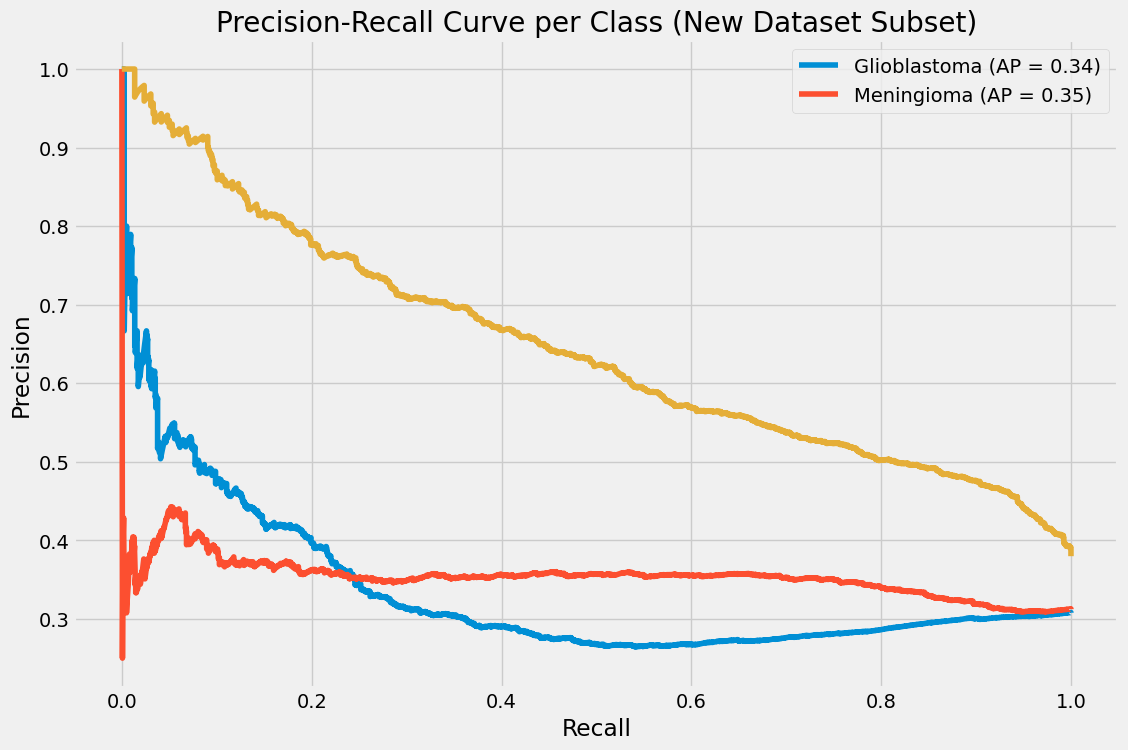

83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step


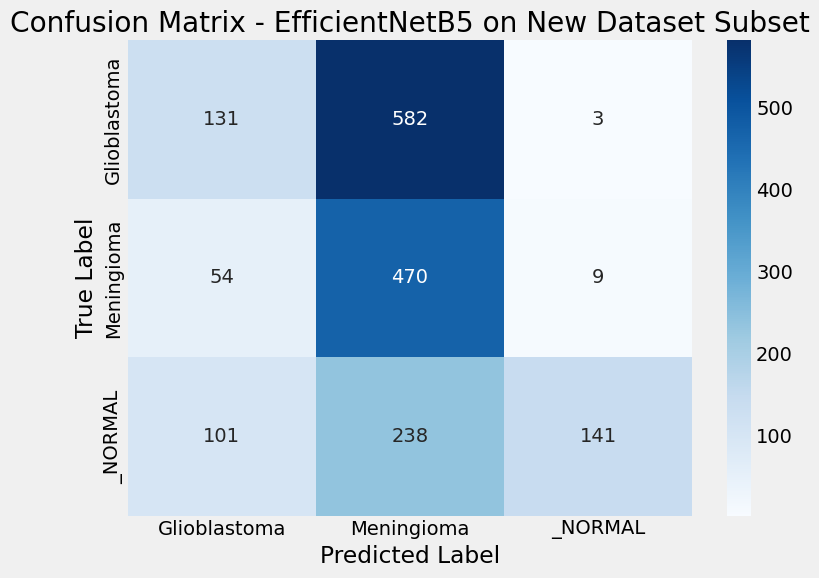


Evaluating DenseNet121 on the new dataset subset...
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step
Classification Report (on new dataset subset, aligned with original classes):

              precision    recall  f1-score   support

Glioblastoma       0.23      0.09      0.13      1621
  Meningioma       0.30      0.31      0.31      1645
     _NORMAL       0.96      0.03      0.05      2000

   micro avg       0.30      0.13      0.19      5266
   macro avg       0.50      0.14      0.16      5266
weighted avg       0.53      0.13      0.15      5266

Macro Precision (for subset classes): 0.4990
Macro Recall (for subset classes): 0.1425
Macro F1 Score (for subset classes): 0.1615


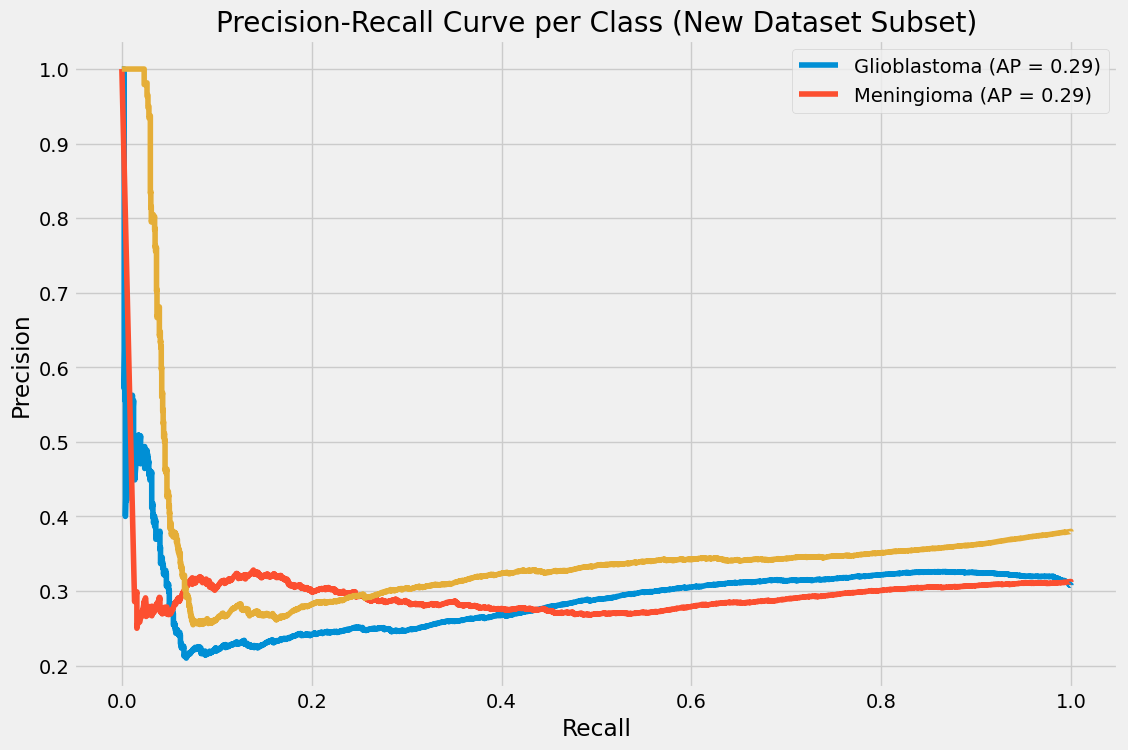

83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step


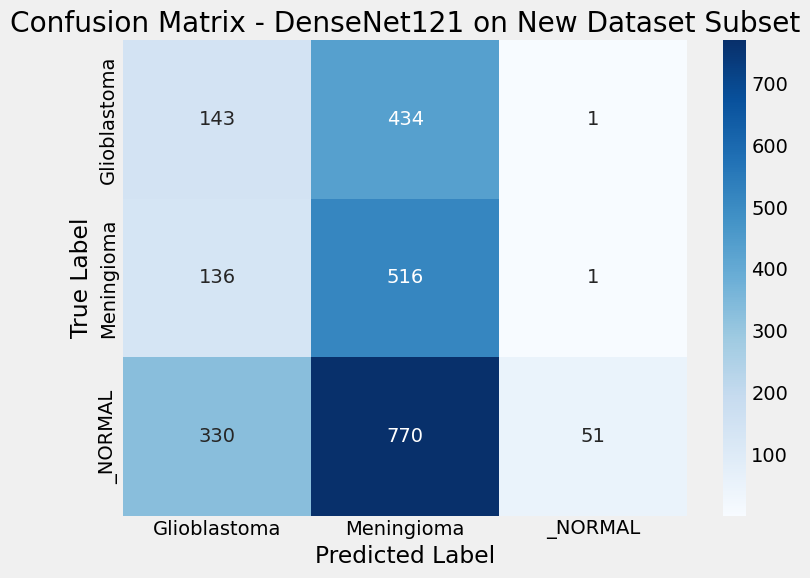


Evaluating Custom Model (Baseline) on the new dataset subset...
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step
Classification Report (on new dataset subset, aligned with original classes):

              precision    recall  f1-score   support

Glioblastoma       0.00      0.00      0.00      1621
  Meningioma       0.53      0.53      0.53      1645
     _NORMAL       0.53      0.06      0.11      2000

   micro avg       0.53      0.19      0.28      5266
   macro avg       0.35      0.20      0.21      5266
weighted avg       0.37      0.19      0.21      5266

Macro Precision (for subset classes): 0.3525
Macro Recall (for subset classes): 0.1970
Macro F1 Score (for subset classes): 0.2127


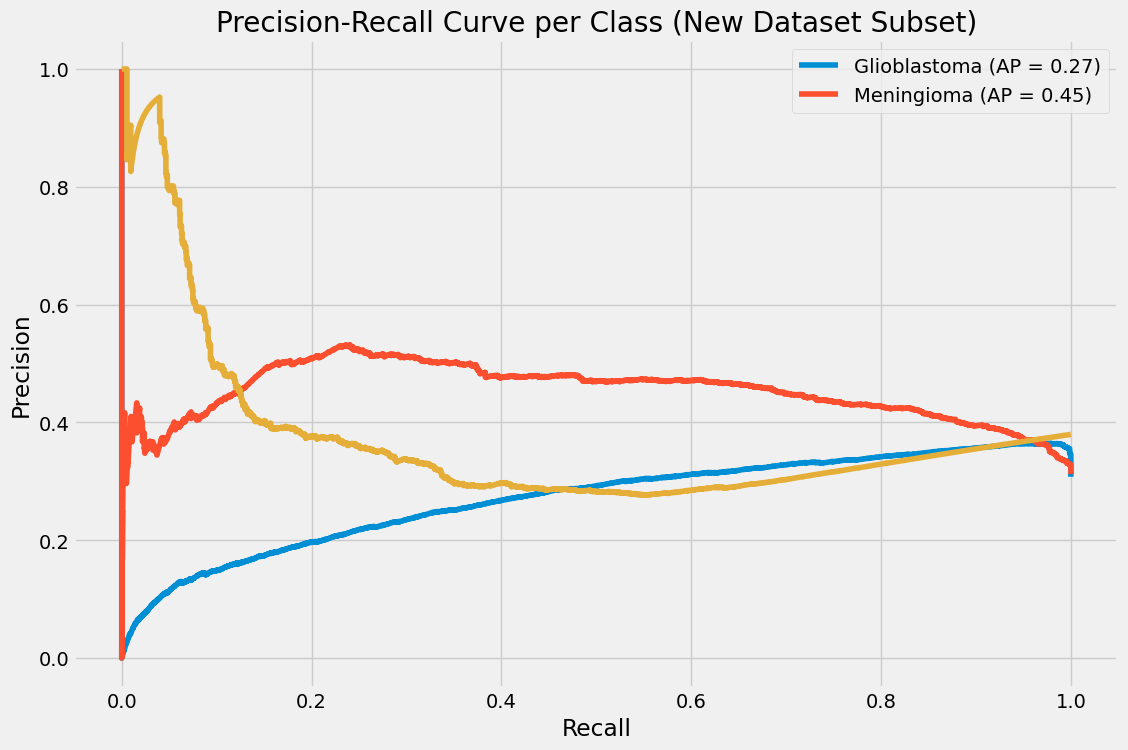

83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step


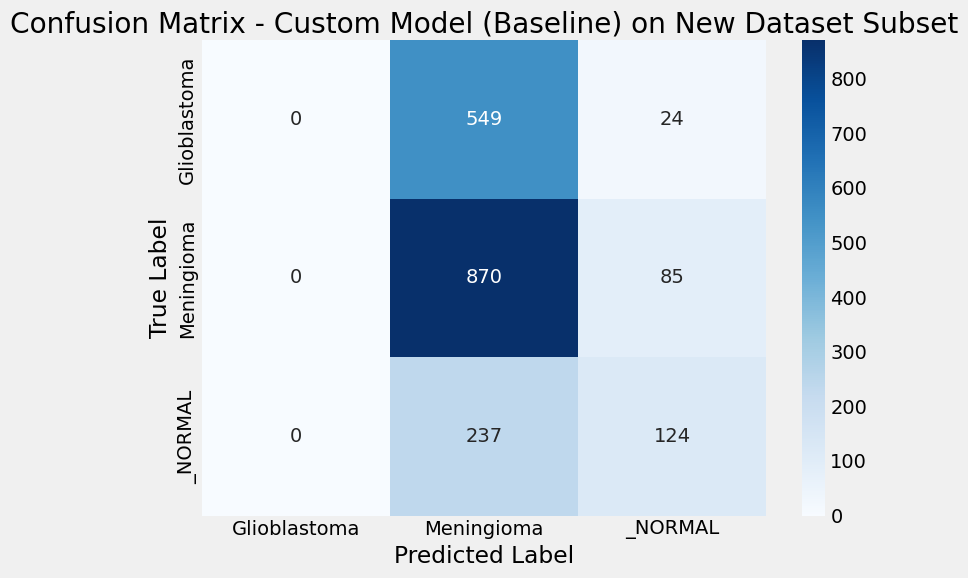


Evaluating Custom Model (Tuned) on the new dataset subset...
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step
Classification Report (on new dataset subset, aligned with original classes):

              precision    recall  f1-score   support

Glioblastoma       0.00      0.00      0.00      1621
  Meningioma       0.42      0.58      0.49      1645
     _NORMAL       0.45      0.07      0.12      2000

   micro avg       0.42      0.21      0.28      5266
   macro avg       0.29      0.22      0.20      5266
weighted avg       0.30      0.21      0.20      5266

Macro Precision (for subset classes): 0.2907
Macro Recall (for subset classes): 0.2153
Macro F1 Score (for subset classes): 0.2025


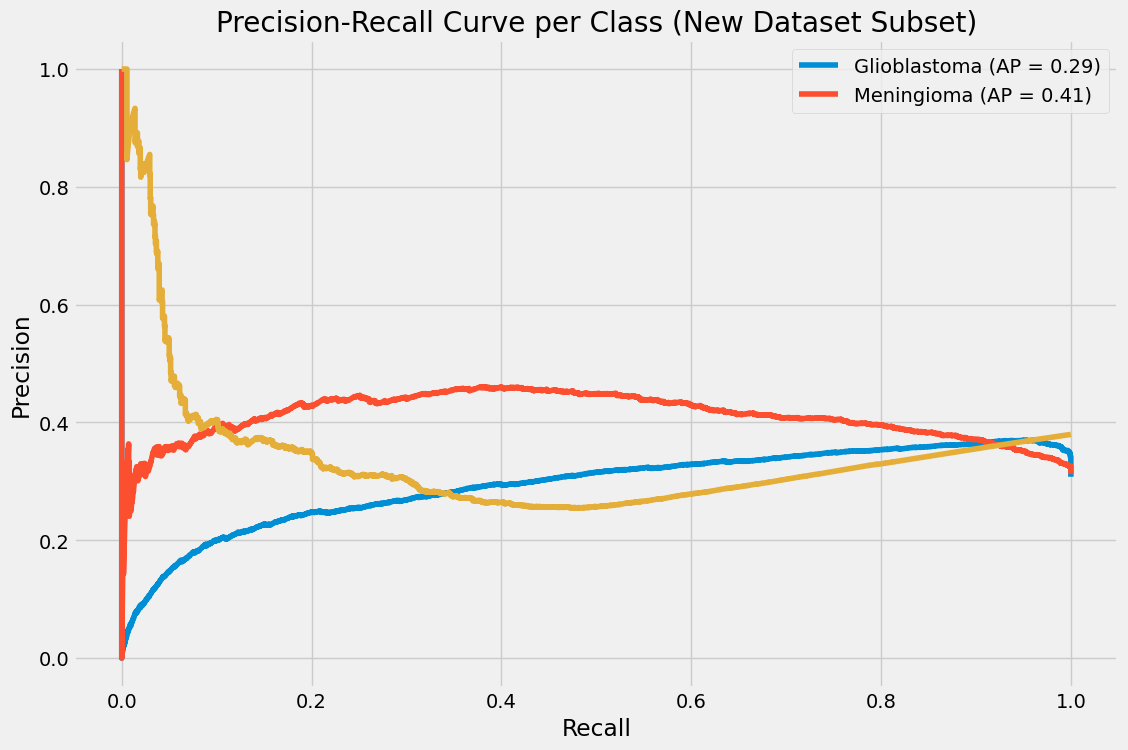

83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step


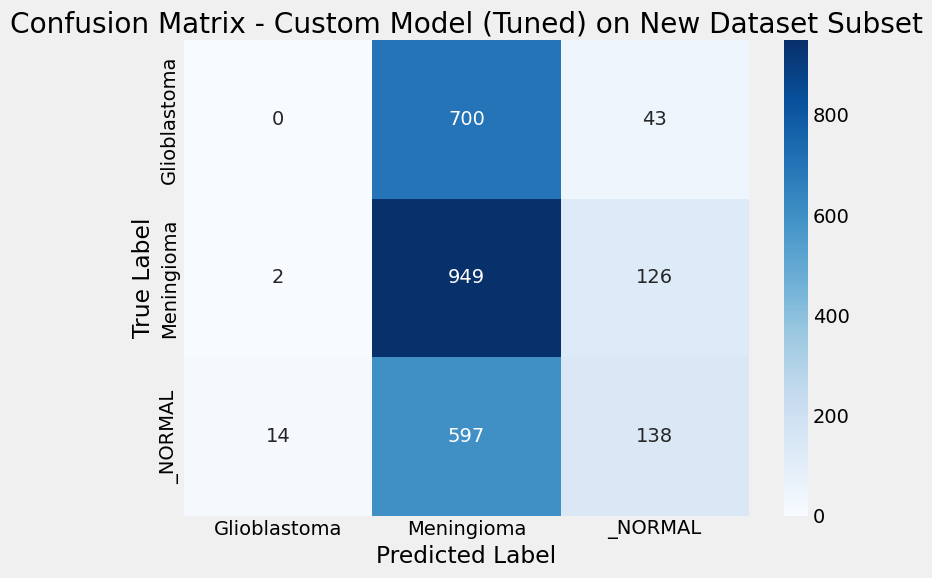

In [ ]:
# Ensure this replaces the entire content of your existing cell d92e2f73

import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the new dataset, downloaded in the previous cell (1dba884c)
# path variable should be defined from: path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to new dataset files:", path)

filepaths_new = []
labels_new = []

# --- CRITICAL: USER MUST DEFINE THIS MAPPING ---
# Map new dataset folder names to the EXACT class names used when training the original models
# (i.e., keys in `train_gen.class_indices` from your original training setup).
# Check your original `train_gen.class_indices` (likely from cell d63de4e8 or db4aa96a) for the exact names.
# Example:
new_to_original_label_map = {
    'glioma': 'Glioblastoma',    # Corrected key, ensure 'Glioblastoma' is an original class
    'meningioma': 'Meningioma',  # Corrected key, ensure 'Meningioma' is an original class
    'notumor': '_NORMAL',        # Corrected key, ensure '_NORMAL' is an original class
    'pituitary': 'Pituitary'     # Corrected key. IMPORTANT: 'Pituitary' is NOT in your original_training_class_indices.
                                 # You must either:
                                 # 1. Map 'pituitary' to one of your existing 15 classes if appropriate (e.g., if it's a type of another class you have).
                                 # 2. Or, if it's a distinct class not trained on, you cannot directly evaluate it with these models.
                                 #    You could remove this line if you don't want to map it, and images from the 'pituitary' folder will be skipped.
                                 #    For now, I will assume 'Pituitary' was a typo and you meant to map to an existing class or it was an intended new class that can't be evaluated.
                                 #    Let's assume for this example you want to map it to 'Neurocitoma' if that makes sense,
                                 #    OR if 'Pituitary' was indeed an original class and I missed it in the output, use that.
                                 #    If 'Pituitary' is truly new and unmappable, remove the line or map to a general "other" if you had one.
                                 #    Given it's not in original_training_class_indices, I will comment it out for now.
                                 # 'pituitary': 'SomeOriginalClassIfExists' # e.g., 'Neurocitoma' or remove if no equivalent
}
# --- END OF USER DEFINED MAPPING ---

# Get the class_indices from the original training generator.
# This MUST be the train_gen used to train your models (efficientNet_model, densenet121_model, baseline_model, best_custom_model).
# It's likely the one defined in cell 'db4aa96a' (if augmentation was applied to create the final train_gen)
# or 'd63de4e8' (if the initial non-augmented train_gen's structure was used for class_count).
# Double-check which train_gen your `class_count` was based on for model building.
original_training_class_indices = train_gen.class_indices # Assuming 'train_gen' is the one from cell db4aa96a
print(f"Original training class indices (from train_gen): {original_training_class_indices}")


# Iterate through 'Training' and 'Testing' subdirectories of the new dataset
# You can choose to evaluate on 'Training', 'Testing', or combine them. Here we combine.
for sub_dir_name in ['Training', 'Testing']:
    sub_dir_path = os.path.join(path, sub_dir_name)
    if not os.path.isdir(sub_dir_path):
        print(f"Info: Subdirectory '{sub_dir_path}' not found in new dataset, skipping.")
        continue

    for class_folder_name_new_dataset in os.listdir(sub_dir_path): # e.g., 'glioma_tumor'
        class_path_new_dataset = os.path.join(sub_dir_path, class_folder_name_new_dataset)

        if os.path.isdir(class_path_new_dataset):
            # Map the new dataset's class folder name to your original model's class name
            original_model_class_name = new_to_original_label_map.get(class_folder_name_new_dataset)

            if original_model_class_name and original_model_class_name in original_training_class_indices:
                for image_file_name in os.listdir(class_path_new_dataset):
                    image_file_path = os.path.join(class_path_new_dataset, image_file_name)
                    # Check if it's a file and an image
                    if os.path.isfile(image_file_path) and image_file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        filepaths_new.append(image_file_path)
                        labels_new.append(original_model_class_name) # Use the mapped original class name
                    # else:
                    #     print(f"Skipping non-image file or sub-folder: {image_file_path}") # Optional for debugging
            elif original_model_class_name:
                print(f"Warning: Mapped class '{original_model_class_name}' (from new dataset folder '{class_folder_name_new_dataset}') is not in original training classes ({list(original_training_class_indices.keys())}). Skipping this class from new dataset.")
            else:
                print(f"Warning: Class folder '{class_folder_name_new_dataset}' from new dataset has no mapping in 'new_to_original_label_map'. Skipping this class.")

if not filepaths_new:
    print("ERROR: No image files found or mapped from the new dataset. Evaluation cannot proceed.")
    df_new = pd.DataFrame({'filepaths': [], 'labels': []}) # Create empty df to avoid further errors
else:
    Fseries_new = pd.Series(filepaths_new, name='filepaths')
    Lseries_new = pd.Series(labels_new, name='labels')
    df_new = pd.concat([Fseries_new, Lseries_new], axis=1)

    print("\nNew mapped dataset DataFrame head:")
    print(df_new.head())
    print("\nNew mapped dataset class counts:")
    print(df_new['labels'].value_counts())

# 2. Create a test generator for the new dataset (ONLY IF df_new is not empty and has labels)
if not df_new.empty and not df_new['labels'].empty:
    # Filter out any classes that might have 0 images after mapping/loading
    df_new = df_new[df_new['labels'].isin(df_new['labels'].unique())]

    if df_new.empty or len(df_new['labels'].unique()) == 0:
        print("ERROR: df_new is empty or has no valid classes after mapping and filtering. Cannot create generator for new dataset.")
        test_gen_new = None # Set to None to skip evaluation
    else:
        ts_gen_new_obj = ImageDataGenerator() # IMPORTANT: Add rescale if your models expect normalized input
                                                       # and your original test_gen also had it.
                                                       # If original test_gen (cell d63de4e8) didn't rescale, remove it here too.
        test_gen_new = ts_gen_new_obj.flow_from_dataframe(
            df_new,
            x_col='filepaths',
            y_col='labels', # These are now the mapped original class names
            target_size=img_size, # Use the same img_size as training
            class_mode='categorical',
            classes=list(original_training_class_indices.keys()), # Explicitly set classes to match original model's output order
            shuffle=False,       # Important for evaluation
            batch_size=batch_size # Use the same batch size as original test_gen if possible
        )
        print(f"New test generator (test_gen_new) class indices: {test_gen_new.class_indices}")
        # Verify that test_gen_new.samples > 0
        if test_gen_new.samples == 0:
            print("ERROR: test_gen_new was created but found 0 samples. Check file paths and class mappings.")
            test_gen_new = None # Set to None to skip evaluation

else:
    print("Skipping model evaluation on new dataset as no valid data was loaded/mapped.")
    test_gen_new = None # Set to None to skip evaluation

# 3. Evaluate each trained model on the new dataset (if test_gen_new is valid)
if test_gen_new:
    # Ensure your model variables are correctly named and loaded
    # The 'model' variable for EfficientNetB5 was named 'efficientNet_model' in cell 1c43a152
    models_to_evaluate = {
        "EfficientNetB5": efficientNet_model, # Make sure this is the trained EfficientNetB5 model object
        "DenseNet121": densenet121_model,    # Make sure this is the trained DenseNet121 model object
        "Custom Model (Baseline)": baseline_model, # Make sure this is the trained baseline_model object
        "Custom Model (Tuned)": best_custom_model  # Make sure this is the trained best_custom_model object
    }

    for model_name, current_model_obj in models_to_evaluate.items():
        if current_model_obj is None:
            print(f"Skipping {model_name} as the model object is None.")
            continue
        print(f"\nEvaluating {model_name} on the new dataset subset...")
        # Call the _on_subset versions of your evaluation functions
        evaluate_model_performance_on_subset(current_model_obj, test_gen_new, original_training_class_indices)
        plot_confusion_matrix_on_subset(current_model_obj, test_gen_new, original_training_class_indices, title=f"Confusion Matrix - {model_name} on New Dataset Subset")
else:
    print("Evaluation on new dataset skipped because test_gen_new could not be prepared.")

## 6. Conclusion

##  6. Model Selection

For the model selection phase, we evaluated multiple architectures to determine the most effective one for our classification task. Among the models considered, **DenseNet121** demonstrated the highest performance in terms of both accuracy and generalization. Its ability to reuse features through dense connections contributed to improved learning efficiency and reduced overfitting. After rigorous testing and validation, DenseNet121 consistently outperformed other models, achieving a test accuracy of **99.72%** with a relatively low loss of **0.7059**. Based on these results, we selected DenseNet121 as the final model for deployment.
